<a href="https://colab.research.google.com/github/cduplan59/CFT_analysis/blob/main/Late_acceleration_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# Colab Notebook — Annexe B model Sigmoide_HD robust fit
# SN (mu + full cov) + CC (H(z) + cov/diag) + BAO (D/rd + cov)
# - Fit robuste (soft_l1)
# - Marginalisation analytique: Mcal (SN), H0 (CC), s=(c/H0)/rd (BAO)
# ============================================

In [ ]:
# Cellule 1  - Général — version "GitHub/Zenodo",

!pip -q install numpy pandas scipy matplotlib requests

import os, shutil, subprocess, zipfile
import numpy as np
import pandas as pd
from scipy.linalg import cho_factor, cho_solve
from scipy.integrate import solve_ivp, cumulative_trapezoid
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

BASE = "/content/CFT_data"
os.makedirs(BASE, exist_ok=True)

def _run(cmd):
    subprocess.check_call(cmd, shell=True)

def ensure_git_repo(url, dest, branch_or_tag=None, depth=1):
    if os.path.exists(dest) and os.path.isdir(os.path.join(dest, ".git")):
        return
    if os.path.exists(dest):
        shutil.rmtree(dest)
    if branch_or_tag:
        _run(f"git clone --depth {depth} --branch {branch_or_tag} {url} {dest}")
    else:
        _run(f"git clone --depth {depth} {url} {dest}")

# --- 1) Repos GitHub ---
ensure_git_repo("https://github.com/CobayaSampler/sn_data.git",
                os.path.join(BASE, "sn_data-master"))
ensure_git_repo("https://github.com/CobayaSampler/bao_data.git",
                os.path.join(BASE, "bao_data-master"))
ensure_git_repo("https://gitlab.com/mmoresco/CCcovariance.git",
                os.path.join(BASE, "CCcovariance-master"))

# Optionnel (si Pantheon+ utilisés directement dans le notebook)
# ensure_git_repo("https://github.com/PantheonPlusSH0ES/DataRelease.git",
#                 os.path.join(BASE, "PantheonPlusSH0ES-DataRelease"))

# --- 2) DES-SN5YR v1.2 depuis Zenodo (record id 12720778) ---
import requests

DES_ZENODO_RECORD_ID = "12720778"
des_dir = os.path.join(BASE, "DES-SN5YR-1.2")
os.makedirs(des_dir, exist_ok=True)

meta = requests.get(f"https://zenodo.org/api/records/{DES_ZENODO_RECORD_ID}", timeout=60).json()
files = meta.get("files", [])

for f in files:
    fname = f.get("key")
    url = f.get("links", {}).get("self")
    if not fname or not url:
        continue
    outpath = os.path.join(des_dir, fname)
    if os.path.exists(outpath) and os.path.getsize(outpath) > 0:
        continue
    with requests.get(url, stream=True, timeout=300) as r:
        r.raise_for_status()
        with open(outpath, "wb") as w:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    w.write(chunk)

# Dézip automatique si un zip est présent
for fname in os.listdir(des_dir):
    if fname.lower().endswith(".zip"):
        zpath = os.path.join(des_dir, fname)
        with zipfile.ZipFile(zpath, "r") as z:
            z.extractall(des_dir)

# --- 3) Chemins locaux utilisés par le reste du notebook ---
PATHS = {
    "sn_data":   os.path.join(BASE, "sn_data-master"),
    "bao_data":  os.path.join(BASE, "bao_data-master"),
    "cc_cov":    os.path.join(BASE, "CCcovariance-master"),
    "des_sn5yr": des_dir,
}

for k, v in PATHS.items():
    print(f"{k:10s} exists: {os.path.exists(v)} | {v}")


sn_data    exists: True | /content/CFT_data/sn_data-master
bao_data   exists: True | /content/CFT_data/bao_data-master
cc_cov     exists: True | /content/CFT_data/CCcovariance-master
des_sn5yr  exists: True | /content/CFT_data/DES-SN5YR-1.2


In [ ]:
# cellule 2 - General

def find_one(patterns, root):
    """Return first match among patterns (glob)."""
    for pat in patterns:
        hits = glob.glob(os.path.join(root, "**", pat), recursive=True)
        if hits:
            return hits[0]
    return None

def head_text(path, n=20):
    print("\n--- HEAD:", path, "---")
    if path is None:
        print("None")
        return
    if path.endswith(".gz"):
        with gzip.open(path, "rt") as f:
            for i in range(n):
                line = f.readline()
                if not line: break
                print(line.rstrip("\n"))
    else:
        with open(path, "r", errors="ignore") as f:
            for i in range(n):
                line = f.readline()
                if not line: break
                print(line.rstrip("\n"))


In [ ]:
# Cellule 3 - General

# ============================================================
# BLOC INTÉGRAL (cellule utilitaires + cellule 3 en un seul bloc)
# - Corrige: glob / gzip non définis
# - Localise: DES-SN5YR v1.2, Pantheon+, DESI 2024 BAO, CC BC03
# - Suppose que BASE et PATHS existent déjà (cellule 1 GitHub/Zenodo)
# ============================================================

import os, glob, gzip, shutil

# -------------------
# utilitaires
# -------------------
def find_one(patterns, root):
    """Return first match among patterns (glob)."""
    if root is None or not os.path.exists(root):
        return None
    for pat in patterns:
        hits = glob.glob(os.path.join(root, "**", pat), recursive=True)
        if hits:
            return sorted(hits)[0]
    return None

def head_text(path, n=10):
    """Print first n lines of a text file (supports .gz)."""
    if path is None:
        print("\n--- HEAD: None ---")
        return
    if not os.path.exists(path):
        print(f"\n--- HEAD: missing file: {path} ---")
        return

    print(f"\n--- HEAD: {path} ---")
    if path.endswith(".gz"):
        with gzip.open(path, "rt") as f:
            for _ in range(n):
                line = f.readline()
                if not line:
                    break
                print(line.rstrip("\n"))
    else:
        with open(path, "r", encoding="utf-8", errors="replace") as f:
            for _ in range(n):
                line = f.readline()
                if not line:
                    break
                print(line.rstrip("\n"))

# -------------------
# SN choice
# -------------------
SN_CHOICE = "PANTHEONPLUS"   # "DES5YR" or "PANTHEONPLUS"

# DES-SN5YR (Zenodo v1.2)
DES5_MU  = find_one(
    ["*DES-SN5YR*HD*MetaData*.csv", "*HD+MetaData*.csv", "*MetaData*.csv"],
    PATHS["des_sn5yr"]
)
DES5_COV = find_one(
    ["*STAT+SYS*.txt.gz", "*STAT+SYS*.gz", "*STAT+SYS*.txt", "*STAT+SYS*"],
    PATHS["des_sn5yr"]
)

# Pantheon+ (sn_data-master)
PPLUS_DAT = find_one(
    ["*Pantheon*SH0ES*.dat", "*Pantheon+SH0ES*.dat"],
    PATHS["sn_data"]
)
PPLUS_COV = find_one(
    ["*Pantheon*STAT*SYS*.cov", "*Pantheon+SH0ES*STAT*SYS*.cov"],
    PATHS["sn_data"]
)

print("DES5 mu:", DES5_MU)
print("DES5 cov:", DES5_COV)
print("Pantheon+ dat:", PPLUS_DAT)
print("Pantheon+ cov:", PPLUS_COV)

# -------------------
# BAO choice (DESI 2024 gaussian combined)
# -------------------
BAO_MEAN = find_one(
    ["desi_2024_gaussian_bao_ALL_GCcomb_mean.txt",
     "*gaussian_bao_ALL_GCcomb_mean*.txt"],
    PATHS["bao_data"]
)
BAO_COV  = find_one(
    ["desi_2024_gaussian_bao_ALL_GCcomb_cov.txt",
     "*gaussian_bao_ALL_GCcomb_cov*.txt"],
    PATHS["bao_data"]
)

print("BAO mean:", BAO_MEAN)
print("BAO cov :", BAO_COV)

# -------------------
# CC choice (BC03) via CCcovariance
# -------------------
CC_TABLE = os.path.join(PATHS["cc_cov"], "data", "HzTable_MM_BC03.dat")
if not os.path.exists(CC_TABLE):
    CC_TABLE = find_one(
        ["HzTable_MM_BC03.dat", "*HzTable*BC03*.dat", "*CC*Hz*.dat"],
        PATHS["cc_cov"]
    )

# Optionnel : copie locale dans BASE pour centraliser les données
if CC_TABLE and os.path.exists(CC_TABLE):
    cc_local = os.path.join(BASE, "HzTable_MM_BC03.dat")
    if not os.path.exists(cc_local):
        shutil.copy(CC_TABLE, cc_local)
    CC_TABLE = cc_local

CC_COV_HINT = find_one(
    ["*cov*.npy", "*Cov*.npy", "*cov*.txt", "*cov*.dat"],
    PATHS["cc_cov"]
)

print("CC table (BC03):", CC_TABLE)
print("CC cov hint:", CC_COV_HINT)

if CC_TABLE is None or not os.path.exists(CC_TABLE):
    raise FileNotFoundError(
        "HzTable_MM_BC03.dat introuvable dans CCcovariance. "
        "Vérifie le clone GitLab en cellule 1."
    )

# -------------------
# Inspect headers
# -------------------
head_text(BAO_MEAN, 30)
head_text(BAO_COV, 10)
head_text(CC_TABLE, 15)
head_text(DES5_MU, 10)
head_text(DES5_COV, 10)


DES5 mu: /content/CFT_data/DES-SN5YR-1.2/DES-SN5YR-1.2/4_DISTANCES_COVMAT/DES-SN5YR_HD+MetaData.csv
DES5 cov: /content/CFT_data/DES-SN5YR-1.2/DES-SN5YR-1.2/4_DISTANCES_COVMAT/STAT+SYS.txt.gz
Pantheon+ dat: /content/CFT_data/sn_data-master/PantheonPlus/Pantheon+SH0ES.dat
Pantheon+ cov: /content/CFT_data/sn_data-master/PantheonPlus/Pantheon+SH0ES_STAT+SYS.cov
BAO mean: /content/CFT_data/bao_data-master/desi_2024_gaussian_bao_ALL_GCcomb_mean.txt
BAO cov : /content/CFT_data/bao_data-master/desi_2024_gaussian_bao_ALL_GCcomb_cov.txt
CC table (BC03): /content/CFT_data/HzTable_MM_BC03.dat
CC cov hint: None

--- HEAD: /content/CFT_data/bao_data-master/desi_2024_gaussian_bao_ALL_GCcomb_mean.txt ---
# [z] [value at z] [quantity]
0.295 7.92512927 DV_over_rs
0.510 13.62003080 DM_over_rs
0.510 20.98334647 DH_over_rs
0.706 16.84645313 DM_over_rs
0.706 20.07872919 DH_over_rs
0.930 21.70841761 DM_over_rs
0.930 17.87612922 DH_over_rs
1.317 27.78720817 DM_over_rs
1.317 13.82372285 DH_over_rs
1.491 26.072

In [ ]:
# cellule 4 - Generel

import gzip
import numpy as np
import pandas as pd
from scipy.linalg import cho_factor, solve_triangular

def load_dense_cov(path):
    """
    Load SN covariance in common formats:
    - First token is N, followed by N*N values (column vector)
    - Or plain NxN whitespace matrix
    Works with .gz or plain text.
    """
    if path is None:
        raise FileNotFoundError("Covariance path is None")

    # Read tokens
    if path.endswith(".gz"):
        with gzip.open(path, "rt") as f:
            tokens = f.read().strip().split()
    else:
        with open(path, "r") as f:
            tokens = f.read().strip().split()

    # Format: N then N*N numbers
    try:
        N = int(float(tokens[0]))
        if len(tokens) == 1 + N*N:
            arr = np.array(list(map(float, tokens[1:])), dtype=np.float64).reshape(N, N)
            return arr
    except Exception:
        pass

    # Fallback: loadtxt (NxN)
    if path.endswith(".gz"):
        with gzip.open(path, "rt") as f:
            arr = np.loadtxt(f, dtype=np.float64)
    else:
        arr = np.loadtxt(path, dtype=np.float64)

    if arr.ndim != 2 or arr.shape[0] != arr.shape[1]:
        raise ValueError(f"Cov matrix not square: shape={arr.shape}")
    return arr

def make_spd_and_cholesky(C, name="C", jitter0_rel=1e-12, max_tries=12):
    """
    Enforce symmetry and numerical positive-definiteness by adding minimal diagonal jitter.
    Returns (C_fixed, cf) where cf=(L, lower=True) from cho_factor and C_fixed = L L^T.
    """
    C = np.array(C, dtype=np.float64, copy=True)
    C = 0.5 * (C + C.T)  # symmetrize

    n = C.shape[0]
    diag = np.diag(C)
    # Ensure positive diagonal
    if np.any(diag <= 0):
        shift = float(abs(np.min(diag)) + 1e-18)
        C += shift * np.eye(n, dtype=np.float64)

    diag = np.diag(C)
    scale = float(np.median(diag))
    if not np.isfinite(scale) or scale <= 0:
        scale = float(np.mean(diag[diag > 0])) if np.any(diag > 0) else 1.0

    jitter = 0.0
    for k in range(max_tries):
        try:
            Cf = C if jitter == 0 else (C + jitter * np.eye(n, dtype=np.float64))
            cf = cho_factor(Cf, lower=True, overwrite_a=False, check_finite=False)
            if k > 0:
                print(f"{name}: Cholesky OK with jitter={jitter:.3e} (rel={jitter/scale:.3e})")
            return Cf, cf
        except np.linalg.LinAlgError:
            if k == 0:
                jitter = jitter0_rel * scale
                print(f"{name}: not PD -> adding jitter starting at {jitter:.3e} (rel={jitter/scale:.3e})")
            else:
                jitter *= 10.0

    raise np.linalg.LinAlgError(f"{name}: failed to make PD after {max_tries} tries (last jitter={jitter:.3e})")

def whiten(cf, r):
    """
    If C = L L^T with L lower, return u = L^{-1} r (whitened residual).
    """
    L, lower = cf
    return solve_triangular(L, r, lower=True, check_finite=False)

def load_sn_des5yr(mu_csv, cov_gz):
    df = pd.read_csv(mu_csv)

    # Required fields
    if "zHD" not in df.columns:
        raise ValueError("DES5YR: expected column zHD not found.")
    if "MU" not in df.columns:
        raise ValueError("DES5YR: expected column MU not found.")

    z = df["zHD"].to_numpy(dtype=np.float64)
    mu = df["MU"].to_numpy(dtype=np.float64)

    C = load_dense_cov(cov_gz)
    if C.shape[0] != len(mu):
        raise ValueError(f"DES5YR cov shape {C.shape} != N_SN {len(mu)}")

    return z, mu, C

def load_sn_pantheon(dat_path, cov_path):
    # Pantheon+ SH0ES typically whitespace with header comments
    df = pd.read_csv(dat_path, comment="#", delim_whitespace=True)
    # Try standard columns
    zcol = "zHD" if "zHD" in df.columns else ("zCMB" if "zCMB" in df.columns else None)
    if zcol is None:
        raise ValueError(f"Pantheon+: cannot find zHD/zCMB. Columns={list(df.columns)}")

    mucol = "MU" if "MU" in df.columns else None
    if mucol is None:
        # fallback: first column containing "mu"
        mucands = [c for c in df.columns if "mu" in c.lower()]
        if not mucands:
            raise ValueError(f"Pantheon+: cannot find MU. Columns={list(df.columns)}")
        mucol = mucands[0]

    z = df[zcol].to_numpy(dtype=np.float64)
    mu = df[mucol].to_numpy(dtype=np.float64)

    C = load_dense_cov(cov_path)
    if C.shape[0] != len(mu):
        raise ValueError(f"Pantheon+ cov shape {C.shape} != N_SN {len(mu)}")

    return z, mu, C

# ---------- Load SN chosen ----------
if SN_CHOICE.upper() == "DES5YR":
    z_sn, mu_sn, C_sn_raw = load_sn_des5yr(DES5_MU, DES5_COV)
elif SN_CHOICE.upper() == "PANTHEONPLUS":
    z_sn, mu_sn, C_sn_raw = load_sn_pantheon(PPLUS_DAT, PPLUS_COV)
else:
    raise ValueError("SN_CHOICE must be DES5YR or PANTHEONPLUS")

print("SN loaded:", len(z_sn), "z in [", float(z_sn.min()), ",", float(z_sn.max()), "]")
print("Cov raw shape:", C_sn_raw.shape, "max|asym|=", float(np.max(np.abs(C_sn_raw - C_sn_raw.T))))

C_sn, cf_sn = make_spd_and_cholesky(C_sn_raw, name="SN_cov")
print("Cov fixed diag median:", float(np.median(np.diag(C_sn))), "diag min:", float(np.min(np.diag(C_sn))))


/tmp/ipython-input-21268390.py:110: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(dat_path, comment="#", delim_whitespace=True)


SN loaded: 1701 z in [ 0.00122 , 2.26137 ]
Cov raw shape: (1701, 1701) max|asym|= 3.0000000000038676e-08
Cov fixed diag median: 0.02419881 diag min: 0.00644455


In [ ]:
# cellule 5  - General


import numpy as np
import pandas as pd
from scipy.linalg import cho_factor

def _norm_obs_label(obs):
    s = str(obs).strip().lower()
    s = s.replace(" ", "").replace("\t", "").replace("\r", "").replace("\n", "")
    return s

# Mean file format:
#   # [z] [value at z] [quantity]
#   0.295 7.925... DV_over_rs
bao = pd.read_csv(
    BAO_MEAN,
    comment="#",
    sep=r"\s+",
    names=["z", "val", "obs"],
    engine="python"
)

C_bao = np.loadtxt(BAO_COV, dtype=np.float64)
if C_bao.ndim != 2 or C_bao.shape[0] != C_bao.shape[1]:
    raise ValueError(f"BAO cov not square: {C_bao.shape}")
if C_bao.shape[0] != len(bao):
    raise ValueError(f"BAO cov size {C_bao.shape} != N_bao {len(bao)}")

cf_bao = cho_factor(C_bao, lower=True, overwrite_a=False, check_finite=False)

print("BAO loaded:", len(bao))
print("BAO head:")
print(bao.head(12))
print("BAO cov shape:", C_bao.shape)
print("BAO unique labels:", sorted(set([str(x) for x in bao["obs"].unique()])))
print("BAO normalized labels:", sorted(set([_norm_obs_label(x) for x in bao["obs"].unique()])))


BAO loaded: 12
BAO head:
        z        val         obs
0   0.295   7.925129  DV_over_rs
1   0.510  13.620031  DM_over_rs
2   0.510  20.983346  DH_over_rs
3   0.706  16.846453  DM_over_rs
4   0.706  20.078729  DH_over_rs
5   0.930  21.708418  DM_over_rs
6   0.930  17.876129  DH_over_rs
7   1.317  27.787208  DM_over_rs
8   1.317  13.823723  DH_over_rs
9   1.491  26.072172  DV_over_rs
10  2.330  39.708383  DM_over_rs
11  2.330   8.522566  DH_over_rs
BAO cov shape: (12, 12)
BAO unique labels: ['DH_over_rs', 'DM_over_rs', 'DV_over_rs']
BAO normalized labels: ['dh_over_rs', 'dm_over_rs', 'dv_over_rs']


In [ ]:
# cellule 6  - General

import numpy as np
import pandas as pd
from scipy.linalg import cho_factor

# HzTable_MM_BC03.dat is comma-separated values with a comment header
cc_df = pd.read_csv(CC_TABLE, comment="#", header=None, sep=",")

# Columns: z, Hz, errHz, stat_contr, met_contr, reference
z_cc  = cc_df.iloc[:,0].to_numpy(dtype=np.float64)
H_cc  = cc_df.iloc[:,1].to_numpy(dtype=np.float64)
sH_cc = cc_df.iloc[:,2].to_numpy(dtype=np.float64)

# Start robust: diagonal covariance (you can upgrade to CCcovariance later)
C_cc = np.diag(sH_cc**2)
cf_cc = cho_factor(C_cc, lower=True, overwrite_a=False, check_finite=False)

print("CC loaded:", len(z_cc), "z in [", float(z_cc.min()), ",", float(z_cc.max()), "]")


CC loaded: 15 z in [ 0.1791 , 1.965 ]


In [ ]:
# cellule 7 - General
gamma0 = 6.0
t_star = 1.0  # arbitrary scale; cancels in E(z) after normalization

def _safe_exp(x):
    return np.exp(np.clip(x, -80, 80))

def HD_and_dHD(z, p7):
    # p7 = [H_hi, H_lo, zt, w, A, sigma, zb]
    H_hi, H_lo, zt, w, A, sig, zb = p7
    u = (z - zt) / max(w, 1e-6)
    # S = 1/(1+exp(u))
    eu = _safe_exp(u)
    S = 1.0 / (1.0 + eu)
    dSdz = -(1.0 / max(w,1e-6)) * S * (1.0 - S)

    G = _safe_exp(-0.5 * ((z - zb)/max(sig,1e-6))**2)
    dGdz = G * (-(z - zb) / max(sig,1e-6)**2)

    HD  = H_hi + (H_lo - H_hi)*S + A*G
    dHD = (H_lo - H_hi)*dSdz + A*dGdz
    return HD, dHD

def make_gfun(z_on, Delta):
    Delta = max(Delta, 1e-4)
    def g(z):
        return 1.0 / (1.0 + _safe_exp((z - z_on)/Delta))
    return g

def solve_y(z_grid, p7, y0, gfun):
    z0, z1 = float(z_grid[0]), float(z_grid[-1])

    def rhs(z, y):
        HD, dHD = HD_and_dHD(z, p7)
        HD = max(float(HD), 1e-9)
        gz = float(gfun(z))
        # dy/dz
        return -gamma0/((1.0+z)*HD) - gz*y*(dHD/HD)

    sol = solve_ivp(rhs, (z0, z1), [y0], t_eval=z_grid, rtol=1e-6, atol=1e-9)
    if not sol.success:
        return None
    return sol.y[0]

def model_E(z_grid, p7, y0, gfun, zref_max=0.02):
    y = solve_y(z_grid, p7, y0, gfun)
    if y is None:
        return None

    HD, dHD = HD_and_dHD(z_grid, p7)
    if np.any(~np.isfinite(HD)) or np.any(HD <= 0):
        return None

    t = t_star * np.exp(y)
    denom = 1.0 + gfun(z_grid) * ((1.0+z_grid)/gamma0) * dHD * y
    if np.any(~np.isfinite(denom)) or np.any(np.abs(denom) < 1e-6):
        return None

    H = HD / (gamma0 * t * denom)

    # Normalize so E(z~0)=1 (H0 absorbed elsewhere)
    mref = (z_grid <= zref_max)
    if not np.any(mref):
        mref = (z_grid == z_grid.min())
    Href = float(np.mean(H[mref]))
    if not np.isfinite(Href) or abs(Href) < 1e-12:
        return None
    return (H / Href)


In [ ]:
# cellule 8 - General

import numpy as np
from scipy.integrate import cumulative_trapezoid

def mu_from_E(z, E):
    r"""
    mu*(z) = 5 log10( (1+z) * ∫_0^z dz'/E(z') ) + Mcal

    Mcal absorbs (c/H0) and the absolute SN magnitude.
    The integral is dimensionless (units of c/H0 factored out).
    """
    # Sort by z
    order = np.argsort(z)
    z2 = z[order]
    E2 = E[order]

    invE = 1.0 / np.maximum(E2, 1e-12)
    chi = cumulative_trapezoid(invE, z2, initial=0.0)

    dL = (1.0 + z2) * np.maximum(chi, 1e-14)
    mu_star = 5.0 * np.log10(dL)

    # Restore original order
    out = np.empty_like(mu_star)
    out[order] = mu_star
    return out


In [ ]:
# cellule 9 - General
def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    num = float(np.dot(Ecc, Cinv_H))
    den = float(np.dot(Ecc, Cinv_E))
    return num/den  # km/s/Mpc


In [ ]:
# cellule 10 - General
import numpy as np
from scipy.integrate import cumulative_trapezoid

def _norm_obs_label(obs):
    # robuste: strip, lower, enlever espaces et caractères parasites simples
    s = str(obs).strip().lower()
    s = s.replace(" ", "").replace("\t", "").replace("\r", "").replace("\n", "")
    return s

def bao_theory_factors(z_bao, obs, z_grid, E_grid):
    """
    Returns f_i(E) so that d_theory = s * f_i, with s=(c/H0)/r_s.
    Supported DESI labels: DM_over_rs, DH_over_rs, DV_over_rs (case/space-insensitive).
    """
    lab = _norm_obs_label(obs)

    invE = 1.0 / np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    chi = np.interp(z_bao, z_grid, chi_grid)
    E   = np.interp(z_bao, z_grid, E_grid)

    if lab == "dm_over_rs":
        return chi
    if lab == "dh_over_rs":
        return 1.0 / np.maximum(E, 1e-12)
    if lab == "dv_over_rs":
        return (z_bao * (chi**2) * (1.0 / np.maximum(E, 1e-12)))**(1.0/3.0)

    # fallback: accept substrings too
    if "dm_over_rs" in lab:
        return chi
    if "dh_over_rs" in lab:
        return 1.0 / np.maximum(E, 1e-12)
    if "dv_over_rs" in lab:
        return (z_bao * (chi**2) * (1.0 / np.maximum(E, 1e-12)))**(1.0/3.0)

    raise ValueError(f"Unsupported BAO observable label: {obs!r} (normalized={lab!r})")


In [ ]:
# Cellule 11 - General

import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.linalg import cho_solve
from scipy.integrate import cumulative_trapezoid

c_km_s = 299792.458

# -------------------------------------------------------
# 0) Grid
# -------------------------------------------------------
zmax = float(max(z_sn.max(), z_cc.max(), bao["z"].max()))
z_grid = np.linspace(0.0, zmax, 1200)   # un peu plus dense pour chi(z)

# -------------------------------------------------------
# 1) Bounds / init / grids
# -------------------------------------------------------
LB = np.array([3.5,  6.0, 0.45, 0.05, 0.0, 0.08, 0.0,  -50.0], dtype=np.float64)
UB = np.array([4.5, 25.0, 0.85, 0.50, 20.0, 0.60, zmax,  50.0], dtype=np.float64)
X0 = np.array([4.0, 10.0, 0.65, 0.12, 1.5, 0.15, 0.65,   0.0], dtype=np.float64)

ZON_GRID   = np.arange(0.55, 0.91, 0.05)
DELTA_GRID = np.array([0.05, 0.07, 0.10, 0.12, 0.15], dtype=np.float64)

# -------------------------------------------------------
# 2) Nuisances
# -------------------------------------------------------
def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

def best_s_from_BAO(bao, cf_bao, z_grid, E_grid):
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    Cinv_d = cho_solve(cf_bao, d, check_finite=False)
    Cinv_f = cho_solve(cf_bao, f, check_finite=False)
    return float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))

# -------------------------------------------------------
# 3) Residuals (whitened)
# -------------------------------------------------------
N_tot = len(mu_sn) + len(z_cc) + len(bao)

def residuals_global(x, z_on, Delta):
    try:
        p7 = x[:7]
        y0 = x[7]
        gfun = make_gfun(z_on, Delta)

        E_grid = model_E(z_grid, p7, y0, gfun)
        if E_grid is None or np.any(~np.isfinite(E_grid)):
            return 1e6 * np.ones(N_tot, dtype=np.float64)

        # --- compute chi(z) ON z_grid (includes z=0) then interpolate to SN
        invE = 1.0 / np.maximum(E_grid, 1e-12)
        chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)
        chi_sn = np.interp(z_sn, z_grid, chi_grid)
        dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
        mu_star = 5.0 * np.log10(dL_sn)

        # --- SN (with full cov)
        Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
        r_sn = (mu_star + Mcal) - mu_sn
        u_sn = whiten(cf_sn, r_sn)

        # --- CC
        H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
        Ecc = np.interp(z_cc, z_grid, E_grid)
        r_cc = (H0 * Ecc) - H_cc
        u_cc = whiten(cf_cc, r_cc)

        # --- BAO
        s_hat = best_s_from_BAO(bao, cf_bao, z_grid, E_grid)
        z_b = bao["z"].to_numpy(np.float64)
        obs = bao["obs"].to_numpy()
        d   = bao["val"].to_numpy(np.float64)
        f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                     dtype=np.float64)
        r_bao = (s_hat * f) - d
        u_bao = whiten(cf_bao, r_bao)

        return np.concatenate([u_sn, u_cc, u_bao])
    except Exception:
        return 1e6 * np.ones(N_tot, dtype=np.float64)

# -------------------------------------------------------
# 4) Scan + refine
# -------------------------------------------------------
rows = []
best_cost = np.inf
best_pack = None

for z_on in ZON_GRID:
    for Delta in DELTA_GRID:
        z_on_f = float(z_on); Delta_f = float(Delta)
        res = least_squares(
            residuals_global, X0,
            bounds=(LB, UB),
            args=(z_on_f, Delta_f),
            loss="soft_l1", f_scale=1.0,
            max_nfev=1500
        )
        ok = bool(res.success) and np.isfinite(res.cost)
        cost = float(res.cost) if np.isfinite(res.cost) else np.inf
        rows.append({"z_on": z_on_f, "Delta": Delta_f, "success": ok, "cost": cost})

        if ok and cost < best_cost:
            best_cost = cost
            best_pack = (z_on_f, Delta_f, res)
            print("New best:", "z_on", z_on_f, "Delta", Delta_f, "cost", best_cost)

df_scan = pd.DataFrame(rows).sort_values("cost")
df_scan.to_csv("best_scan_debug.csv", index=False)
print("Saved scan table: best_scan_debug.csv")

if best_pack is None:
    raise RuntimeError("Scan failed: no successful solution found.")

z_on_best, Delta_best, res0 = best_pack

res_best = least_squares(
    residuals_global, res0.x,
    bounds=(LB, UB),
    args=(z_on_best, Delta_best),
    loss="soft_l1", f_scale=1.0,
    max_nfev=8000
)

print("\n=== BEST refined ===")
print("z_on_best =", z_on_best, "Delta_best =", Delta_best)
print("success   =", bool(res_best.success))
print("cost      =", float(res_best.cost))
print("x         =", res_best.x)


New best: z_on 0.55 Delta 0.05 cost 582.9414321420693
New best: z_on 0.55 Delta 0.07 cost 578.1354412208475
New best: z_on 0.55 Delta 0.1 cost 577.8583617517635
New best: z_on 0.55 Delta 0.12 cost 577.60370380159
New best: z_on 0.55 Delta 0.15 cost 577.1206964217803
New best: z_on 0.6500000000000001 Delta 0.1 cost 576.8519406757898
New best: z_on 0.6500000000000001 Delta 0.12 cost 576.6839437660431
New best: z_on 0.7000000000000002 Delta 0.15 cost 576.6784367529558
Saved scan table: best_scan_debug.csv

=== BEST refined ===
z_on_best = 0.7000000000000002 Delta_best = 0.15
success   = True
cost      = 576.6092160859127
x         = [ 3.5         6.09217118  0.67173614  0.43849432  0.23595574  0.1426724
  0.71998578 -0.15561383]


In [ ]:
# cellule 12 - General

# ============================================================
# CELL 12 (REPLACEMENT) — Baseline diagnostics + tests + auto LB/UB (no-bump)
# Run AFTER Cell 11 (requires: res_best, z_on_best, Delta_best, model_E, make_gfun,
# bao_theory_factors, z_sn, mu_sn, cf_sn, z_cc, H_cc, cf_cc, bao, cf_bao)
# ============================================================

import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.linalg import cho_solve, solve_triangular
from scipy.integrate import cumulative_trapezoid, solve_ivp

# -------------------------------
# 0) Sanity checks
# -------------------------------
_required = [
    "res_best", "z_on_best", "Delta_best",
    "model_E", "make_gfun", "bao_theory_factors",
    "z_sn", "mu_sn", "cf_sn",
    "z_cc", "H_cc", "cf_cc",
    "bao", "cf_bao",
]
missing = [k for k in _required if k not in globals()]
if missing:
    raise NameError(
        "Missing variables/functions: " + ", ".join(missing)
        + ". Run Cell 11 and earlier setup cells in the same session."
    )

c_km_s = 299792.458
gamma0 = float(globals().get("gamma0", 6.0))
t_star = float(globals().get("t_star", 1.0))

# -------------------------------
# 1) Utilities
# -------------------------------
if "whiten" not in globals():
    def whiten(cf, r):
        """Return whitened residuals w = U^{-1} r if A = U^T U (or L^{-1} r if lower)."""
        c, lower = cf
        return solve_triangular(c, r, lower=lower, check_finite=False)

def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

def best_s_from_BAO(bao, cf_bao, z_grid, E_grid):
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    Cinv_d = cho_solve(cf_bao, d, check_finite=False)
    Cinv_f = cho_solve(cf_bao, f, check_finite=False)
    return float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))

def count_bound_hits(x, LB, UB, tol=1e-10):
    hits = []
    for i, (xi, lo, hi) in enumerate(zip(x, LB, UB)):
        if abs(xi - lo) <= tol:
            hits.append((i, "LOWER", float(lo)))
        if abs(xi - hi) <= tol:
            hits.append((i, "UPPER", float(hi)))
    return hits

def eval_fit_blocks(x, z_grid, E_grid, chi_grid):
    """Compute nuisances + chi2 splits given E_grid and chi_grid."""
    # SN
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0 * np.log10(dL_sn)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = whiten(cf_sn, r_sn)

    # CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (H0 * Ecc) - H_cc
    u_cc = whiten(cf_cc, r_cc)

    # BAO
    s_hat = best_s_from_BAO(bao, cf_bao, z_grid, E_grid)
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (s_hat * f) - d
    u_bao = whiten(cf_bao, r_bao)

    chi2_SN  = float(np.dot(u_sn,  u_sn))
    chi2_CC  = float(np.dot(u_cc,  u_cc))
    chi2_BAO = float(np.dot(u_bao, u_bao))
    chi2_tot = chi2_SN + chi2_CC + chi2_BAO
    rd_eff = (c_km_s / H0) / s_hat

    return {
        "H0": H0, "s_hat": s_hat, "rd_eff": rd_eff, "Mcal": Mcal,
        "chi2_SN": chi2_SN, "chi2_CC": chi2_CC, "chi2_BAO": chi2_BAO, "chi2_tot": chi2_tot,
        "Nd_SN": len(mu_sn), "Nd_CC": len(z_cc), "Nd_BAO": len(bao), "Nd_tot": len(mu_sn) + len(z_cc) + len(bao),
    }

def make_z_grid():
    zmax = float(max(z_sn.max(), z_cc.max(), bao["z"].max()))
    return np.linspace(0.0, zmax, 1200)

# -------------------------------
# 2) BASELINE diagnostics (from res_best, gating best, bump allowed)
# -------------------------------
z_grid = make_z_grid()
gfun_best = make_gfun(float(z_on_best), float(Delta_best))

x_base = res_best.x.copy()
p7_base, y0_base = x_base[:7], x_base[7]
E_grid_base = model_E(z_grid, p7_base, y0_base, gfun_best)
invE = 1.0 / np.maximum(E_grid_base, 1e-12)
chi_grid_base = cumulative_trapezoid(invE, z_grid, initial=0.0)
base = eval_fit_blocks(x_base, z_grid, E_grid_base, chi_grid_base)

print("=== BASELINE (gating+bump) ===")
print("z_on,Delta =", float(z_on_best), float(Delta_best))
print("cost =", float(res_best.cost))
print("x =", x_base)
print("H0 =", base["H0"])
print("rd_eff =", base["rd_eff"])
print("Mcal =", base["Mcal"])
print("chi2_SN  =", base["chi2_SN"],  "Nd=", base["Nd_SN"],  "chi2/N=", base["chi2_SN"]/base["Nd_SN"])
print("chi2_CC  =", base["chi2_CC"],  "Nd=", base["Nd_CC"],  "chi2/N=", base["chi2_CC"]/base["Nd_CC"])
print("chi2_BAO =", base["chi2_BAO"], "Nd=", base["Nd_BAO"], "chi2/N=", base["chi2_BAO"]/base["Nd_BAO"])
print("chi2_tot =", base["chi2_tot"], "Nd_tot=", base["Nd_tot"])
print()

# -------------------------------
# 3) TEST 1 — g(z) ≡ 1 (no gating), bump allowed
# -------------------------------
def gfun_const(z):
    return np.ones_like(z, dtype=np.float64) if np.ndim(z) else 1.0

# bounds for full 8D baseline model (same shape as res_best.x)
LB8 = np.array([3.5,  6.0, 0.45, 0.05, 0.0, 0.08, 0.0, -50.0], dtype=np.float64)
UB8 = np.array([4.5, 25.0, 0.85, 0.50, 20.0, 0.60, float(z_grid[-1]), 50.0], dtype=np.float64)

Nsn, Ncc, Nbao = len(mu_sn), len(z_cc), len(bao)
Ntot = Nsn + Ncc + Nbao

def residuals_g1(x):
    p7, y0 = x[:7], x[7]
    E_grid = model_E(z_grid, p7, y0, gfun_const)
    if E_grid is None or np.any(~np.isfinite(E_grid)):
        return 1e6 * np.ones(Ntot, dtype=np.float64)
    invE = 1.0 / np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)
    out = eval_fit_blocks(x, z_grid, E_grid, chi_grid)
    # rebuild whitened residual concatenation (needed for least_squares)
    # SN
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0 * np.log10(dL_sn)
    Mcal = out["Mcal"]
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = whiten(cf_sn, r_sn)
    # CC
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (out["H0"] * Ecc) - H_cc
    u_cc = whiten(cf_cc, r_cc)
    # BAO
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (out["s_hat"] * f) - d
    u_bao = whiten(cf_bao, r_bao)
    return np.concatenate([u_sn, u_cc, u_bao])

x0_g1 = np.clip(x_base.copy(), LB8 + 1e-12, UB8 - 1e-12)

res_g1 = least_squares(
    residuals_g1, x0_g1,
    bounds=(LB8, UB8),
    loss="soft_l1", f_scale=1.0,
    max_nfev=8000
)

x_g1 = res_g1.x.copy()
p7_g1, y0_g1 = x_g1[:7], x_g1[7]
E_grid_g1 = model_E(z_grid, p7_g1, y0_g1, gfun_const)
invE = 1.0 / np.maximum(E_grid_g1, 1e-12)
chi_grid_g1 = cumulative_trapezoid(invE, z_grid, initial=0.0)
g1 = eval_fit_blocks(x_g1, z_grid, E_grid_g1, chi_grid_g1)

print("=== TEST 1: g(z)=1 (no gating), bump allowed ===")
print("cost =", float(res_g1.cost))
print("x =", x_g1)
print("H0 =", g1["H0"])
print("rd_eff =", g1["rd_eff"])
print("Mcal =", g1["Mcal"])
print("chi2_SN  =", g1["chi2_SN"],  "Nd=", g1["Nd_SN"],  "chi2/N=", g1["chi2_SN"]/g1["Nd_SN"])
print("chi2_CC  =", g1["chi2_CC"],  "Nd=", g1["Nd_CC"],  "chi2/N=", g1["chi2_CC"]/g1["Nd_CC"])
print("chi2_BAO =", g1["chi2_BAO"], "Nd=", g1["Nd_BAO"], "chi2/N=", g1["chi2_BAO"]/g1["Nd_BAO"])
print("chi2_tot =", g1["chi2_tot"], "Nd_tot=", g1["Nd_tot"])
print("bound hits:", count_bound_hits(x_g1, LB8, UB8))
print()

# -------------------------------
# 4) TEST 2 — no-bump model (A≡0 removed), with AUTO search for LB/UB (zt_low, w_high)
#     Parameters: [H_hi, H_lo, zt, w, y0]
# -------------------------------
def HD_and_dHD_A0(z, p4):
    H_hi, H_lo, zt, w = p4
    u = (z - zt) / w
    S = 1.0 / (1.0 + np.exp(u))
    dSdz = -(1.0 / w) * S * (1.0 - S)
    HD  = H_hi + (H_lo - H_hi) * S
    dHD = (H_lo - H_hi) * dSdz
    return HD, dHD

def solve_y_A0(z_grid, p4, y_init, gfun):
    def rhs(z, y):
        HD, dHD = HD_and_dHD_A0(z, p4)
        HD = max(HD, 1e-12)
        gz = gfun(z)
        return -gamma0 / ((1.0 + z) * HD) - gz * y * (dHD / HD)

    sol = solve_ivp(rhs, (z_grid[0], z_grid[-1]), [y_init],
                    t_eval=z_grid, rtol=1e-6, atol=1e-9)
    if not sol.success:
        return None
    return sol.y[0]

def model_E_A0(z_grid, p4, y_init, gfun):
    y = solve_y_A0(z_grid, p4, y_init, gfun)
    if y is None:
        return None
    HD, dHD = HD_and_dHD_A0(z_grid, p4)
    if np.any(HD <= 0) or np.any(~np.isfinite(HD)):
        return None
    t = t_star * np.exp(y)
    denom = 1.0 + gfun(z_grid) * ((1.0 + z_grid) / gamma0) * dHD * y
    if np.any(~np.isfinite(denom)) or np.any(np.abs(denom) < 1e-6):
        return None
    H = HD / (gamma0 * t * denom)
    H_ref = np.mean(H[(z_grid >= z_grid[0]) & (z_grid <= 0.02)])
    return H / H_ref

def residuals_A0(x, LB, UB, gfun):
    # x = [H_hi,H_lo,zt,w,y0]
    p4, y0 = x[:4], x[4]
    E_grid = model_E_A0(z_grid, p4, y0, gfun)
    if E_grid is None or np.any(~np.isfinite(E_grid)):
        return 1e6 * np.ones(Ntot, dtype=np.float64)
    invE = 1.0 / np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)
    # SN
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0 * np.log10(dL_sn)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = whiten(cf_sn, r_sn)
    # CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (H0 * Ecc) - H_cc
    u_cc = whiten(cf_cc, r_cc)
    # BAO
    s_hat = best_s_from_BAO(bao, cf_bao, z_grid, E_grid)
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (s_hat * f) - d
    u_bao = whiten(cf_bao, r_bao)
    return np.concatenate([u_sn, u_cc, u_bao])

def eval_A0_solution(res, LB, UB, gfun):
    x = res.x.copy()
    p4, y0 = x[:4], x[4]
    E_grid = model_E_A0(z_grid, p4, y0, gfun)
    invE = 1.0 / np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)
    out = eval_fit_blocks(x, z_grid, E_grid, chi_grid)
    out["cost"] = float(res.cost)
    out["x"] = x
    out["LB"] = LB.copy()
    out["UB"] = UB.copy()
    out["hits"] = count_bound_hits(x, LB, UB)
    out["n_hits"] = len(out["hits"])
    return out

# ---- auto search space for bounds (focus on zt_low and w_high)
zt_low_grid = [0.10, 0.05, 0.02, 0.00]
w_high_grid = [2.0, 3.0, 5.0]

# fixed broad bounds for other params in no-bump
Hhi_low, Hhi_high = 3.0, 6.0
Hlo_low, Hlo_high = 5.0, 25.0
zt_high = 1.20
w_low = 0.03
y0_low, y0_high = -50.0, 50.0

# init from baseline projection
x0_A0 = np.array([x_base[0], x_base[1], x_base[2], x_base[3], x_base[7]], dtype=np.float64)

cands = []
for zt_low in zt_low_grid:
    for w_high in w_high_grid:
        LB5 = np.array([Hhi_low, Hlo_low, zt_low,  w_low,  y0_low], dtype=np.float64)
        UB5 = np.array([Hhi_high, Hlo_high, zt_high, w_high, y0_high], dtype=np.float64)

        x0 = np.clip(x0_A0.copy(), LB5 + 1e-9, UB5 - 1e-9)

        res = least_squares(
            lambda x: residuals_A0(x, LB5, UB5, gfun_best),
            x0,
            bounds=(LB5, UB5),
            loss="soft_l1", f_scale=1.0,
            max_nfev=2500
        )
        out = eval_A0_solution(res, LB5, UB5, gfun_best)

        # objective: prefer low chi2_tot, penalize bound hits
        out["objective"] = out["chi2_tot"] + 50.0 * out["n_hits"]
        cands.append(out)

df_cands = pd.DataFrame([{
    "zt_low": d["LB"][2], "w_high": d["UB"][3],
    "cost": d["cost"], "chi2_tot": d["chi2_tot"],
    "chi2_SN": d["chi2_SN"], "chi2_CC": d["chi2_CC"], "chi2_BAO": d["chi2_BAO"],
    "H0": d["H0"], "rd_eff": d["rd_eff"],
    "n_hits": d["n_hits"], "objective": d["objective"],
} for d in cands]).sort_values(["objective","chi2_tot"])

print("=== AUTO-SEARCH no-bump bounds (scan) ===")
print(df_cands.head(10).to_string(index=False))
print()

best_idx = int(df_cands.index[0])
best_cand = cands[list(df_cands.index).index(best_idx)] if False else None
# safer mapping:
best_row = df_cands.iloc[0]
best_zt_low = float(best_row["zt_low"])
best_w_high = float(best_row["w_high"])

LB_best = np.array([Hhi_low, Hlo_low, best_zt_low,  w_low,  y0_low], dtype=np.float64)
UB_best = np.array([Hhi_high, Hlo_high, zt_high, best_w_high, y0_high], dtype=np.float64)
x0_best = np.clip(x0_A0.copy(), LB_best + 1e-9, UB_best - 1e-9)

# refine best bounds
res_A0_best = least_squares(
    lambda x: residuals_A0(x, LB_best, UB_best, gfun_best),
    x0_best,
    bounds=(LB_best, UB_best),
    loss="soft_l1", f_scale=1.0,
    max_nfev=8000
)
A0_best = eval_A0_solution(res_A0_best, LB_best, UB_best, gfun_best)

print("=== TEST 2: no-bump (A≡0 removed) — BEST bounds after auto-search ===")
print("LB =", A0_best["LB"])
print("UB =", A0_best["UB"])
print("cost =", A0_best["cost"])
print("x =", A0_best["x"], " (H_hi,H_lo,zt,w,y0)")
print("H0 =", A0_best["H0"])
print("rd_eff =", A0_best["rd_eff"])
print("Mcal =", A0_best["Mcal"])
print("chi2_SN  =", A0_best["chi2_SN"],  "Nd=", A0_best["Nd_SN"],  "chi2/N=", A0_best["chi2_SN"]/A0_best["Nd_SN"])
print("chi2_CC  =", A0_best["chi2_CC"],  "Nd=", A0_best["Nd_CC"],  "chi2/N=", A0_best["chi2_CC"]/A0_best["Nd_CC"])
print("chi2_BAO =", A0_best["chi2_BAO"], "Nd=", A0_best["Nd_BAO"], "chi2/N=", A0_best["chi2_BAO"]/A0_best["Nd_BAO"])
print("chi2_tot =", A0_best["chi2_tot"], "Nd_tot=", A0_best["Nd_tot"])
print("bound hits:", A0_best["hits"])
print()

# -------------------------------
# 5) Final comparison table
# -------------------------------
summary = pd.DataFrame([
    {"model":"Baseline (gating+bump)", "H0":base["H0"], "rd":base["rd_eff"], "chi2_SN":base["chi2_SN"], "chi2_CC":base["chi2_CC"], "chi2_BAO":base["chi2_BAO"], "chi2_tot":base["chi2_tot"]},
    {"model":"g=1 (no gating, bump)",  "H0":g1["H0"],   "rd":g1["rd_eff"],   "chi2_SN":g1["chi2_SN"],   "chi2_CC":g1["chi2_CC"],   "chi2_BAO":g1["chi2_BAO"],   "chi2_tot":g1["chi2_tot"]},
    {"model":"no-bump (auto bounds)",  "H0":A0_best["H0"], "rd":A0_best["rd_eff"], "chi2_SN":A0_best["chi2_SN"], "chi2_CC":A0_best["chi2_CC"], "chi2_BAO":A0_best["chi2_BAO"], "chi2_tot":A0_best["chi2_tot"]},
])

print("=== SUMMARY ===")
print(summary.to_string(index=False))

# Export for your paper/notebook logs
summary.to_csv("summary_baseline_vs_tests.csv", index=False)
df_cands.to_csv("scan_nobump_bounds.csv", index=False)
print("\nSaved: summary_baseline_vs_tests.csv")
print("Saved: scan_nobump_bounds.csv")
import numpy as np
from scipy.linalg import cho_solve
from scipy.optimize import least_squares
from scipy.integrate import cumulative_trapezoid

c_km_s = 299792.458

# -------------------------------------------------------
# 0) Grid for all theory evaluations
# -------------------------------------------------------
zmax = float(max(z_sn.max(), z_cc.max(), bao["z"].max()))
z_grid = np.linspace(0.0, zmax, 900)

# -------------------------------------------------------
# 1) Fit bounds and initial point
# -------------------------------------------------------
LB = np.array([3.0, 5.0, 0.10, 0.03, -50.0], dtype=np.float64)
UB = np.array([6.0, 25.0, 1.20, 2.00,  50.0], dtype=np.float64)

X0 = np.array([4.0, 10.0, 0.65, 0.12, 1.5, 0.15, 0.65,   0.0], dtype=np.float64)

ZON_GRID   = np.arange(0.55, 0.91, 0.05)
DELTA_GRID = np.array([0.05, 0.07, 0.10, 0.12, 0.15], dtype=np.float64)

# -------------------------------------------------------
# 2) SN theory: mu*(z) (dimensionless dL) + analytic Mcal
# -------------------------------------------------------
def mu_from_E(z, E):
    # sorted integral
    order = np.argsort(z)
    z2 = z[order]
    E2 = E[order]
    invE = 1.0 / np.maximum(E2, 1e-12)
    chi = cumulative_trapezoid(invE, z2, initial=0.0)
    dL = (1.0 + z2) * np.maximum(chi, 1e-14)
    mu_star = 5.0 * np.log10(dL)
    out = np.empty_like(mu_star)
    out[order] = mu_star
    return out

def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

# -------------------------------------------------------
# 3) CC: analytic H0
# -------------------------------------------------------
def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

# -------------------------------------------------------
# 4) BAO: analytic scale s=(c/H0)/r_s
# -------------------------------------------------------
def best_s_from_BAO(bao, cf_bao, z_grid, E_grid):
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)

    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)

    Cinv_d = cho_solve(cf_bao, d, check_finite=False)
    Cinv_f = cho_solve(cf_bao, f, check_finite=False)
    return float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))

# -------------------------------------------------------
# 5) Global whitened residuals


=== BASELINE (gating+bump) ===
z_on,Delta = 0.7000000000000002 0.15
cost = 576.6092160859127
x = [ 3.5         6.09217118  0.67173614  0.43849432  0.23595574  0.1426724
  0.71998578 -0.15561383]
H0 = 66.99094862079599
rd_eff = 149.05070045363576
Mcal = 43.062570495357775
chi2_SN  = 1744.047164208219 Nd= 1701 chi2/N= 1.0253069748431622
chi2_CC  = 7.509751534510785 Nd= 15 chi2/N= 0.5006501023007189
chi2_BAO = 4.606783855889073 Nd= 12 chi2/N= 0.38389865465742273
chi2_tot = 1756.163699598619 Nd_tot= 1728

=== TEST 1: g(z)=1 (no gating), bump allowed ===
cost = 585.5148702565646
x = [4.5        6.12287589 0.45       0.5        0.02710185 0.12232746
 0.94120468 0.118835  ]
H0 = 66.49951343364413
rd_eff = 150.69494467787771
Mcal = 43.08038765089496
chi2_SN  = 1751.4044936131545 Nd= 1701 chi2/N= 1.029632271377516
chi2_CC  = 8.769915438249365 Nd= 15 chi2/N= 0.5846610292166243
chi2_BAO = 18.164411665887645 Nd= 12 chi2/N= 1.5137009721573038
chi2_tot = 1778.3388207172916 Nd_tot= 1728
bound hits: [

In [ ]:
# Cellule 13 General

import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.linalg import cho_solve

# --- recompute whitened residual blocks at best-fit
x = res_best.x
p7 = x[:7]; y0 = x[7]
gfun = make_gfun(z_on_best, Delta_best)

E_grid = model_E(z_grid, p7, y0, gfun)
invE = 1.0 / np.maximum(E_grid, 1e-12)
chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

# SN
chi_sn = np.interp(z_sn, z_grid, chi_grid)
dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
mu_star = 5.0 * np.log10(dL_sn)

r = mu_sn - mu_star
Cinv_r = cho_solve(cf_sn, r, check_finite=False)
Cinv_1 = cho_solve(cf_sn, np.ones_like(r), check_finite=False)
Mcal = float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

r_sn = (mu_star + Mcal) - mu_sn
u_sn = whiten(cf_sn, r_sn)

# CC
Ecc = np.interp(z_cc, z_grid, E_grid)
Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
H0 = float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

r_cc = (H0 * Ecc) - H_cc
u_cc = whiten(cf_cc, r_cc)

# BAO
z_b = bao["z"].to_numpy(np.float64)
obs = bao["obs"].to_numpy()
d   = bao["val"].to_numpy(np.float64)
f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))], dtype=np.float64)

Cinv_d = cho_solve(cf_bao, d, check_finite=False)
Cinv_f = cho_solve(cf_bao, f, check_finite=False)
s_hat = float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))

r_bao = (s_hat * f) - d
u_bao = whiten(cf_bao, r_bao)

# --- chi2 splits
chi2_sn  = float(np.dot(u_sn,  u_sn))
chi2_cc  = float(np.dot(u_cc,  u_cc))
chi2_bao = float(np.dot(u_bao, u_bao))

print("H0 =", H0)
print("s_hat =", s_hat, "=> rd_eff =", (299792.458/H0)/s_hat)
print("Mcal =", Mcal)
print()
print("chi2_SN  =", chi2_sn,  "Nd=", len(u_sn),  "chi2/N=", chi2_sn/len(u_sn))
print("chi2_CC  =", chi2_cc,  "Nd=", len(u_cc),  "chi2/N=", chi2_cc/len(u_cc))
print("chi2_BAO =", chi2_bao, "Nd=", len(u_bao), "chi2/N=", chi2_bao/len(u_bao))
print("chi2_tot =", chi2_sn+chi2_cc+chi2_bao, "Nd_tot=", len(u_sn)+len(u_cc)+len(u_bao))


H0 = 66.96003684387567
s_hat = 30.03798205057305 => rd_eff = 149.05078427259187
Mcal = 43.063578671018156

chi2_SN  = 1744.120804804719 Nd= 1701 chi2/N= 1.0253502673749082
chi2_CC  = 7.509753335891466 Nd= 15 chi2/N= 0.5006502223927644
chi2_BAO = 4.606861862463893 Nd= 12 chi2/N= 0.38390515520532437
chi2_tot = 1756.2374200030742 Nd_tot= 1728


H0_best   = 66.96003684387567 km/s/Mpc
rd_best   = 149.05078427259187 Mpc (effective from CC+BAO)
Mcal_best = 43.14351419339515


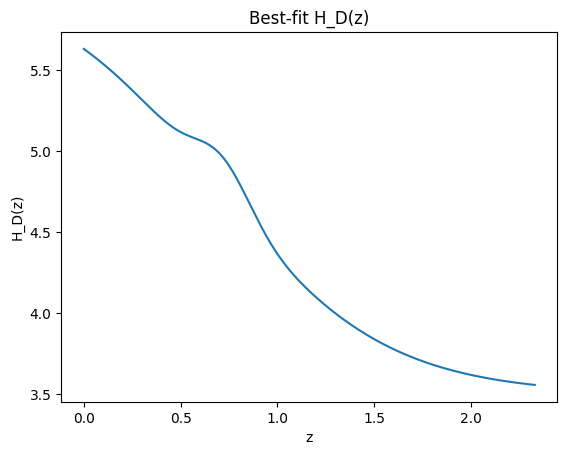

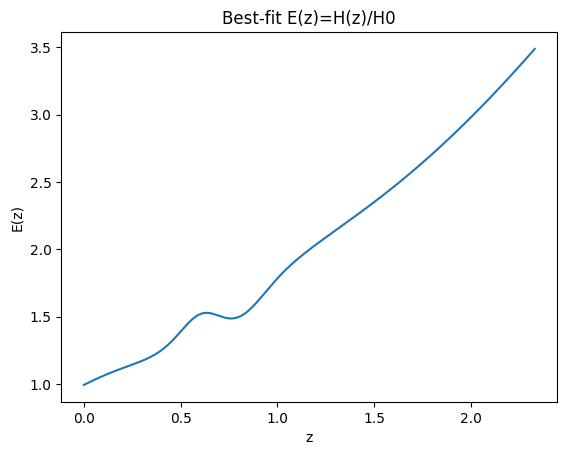

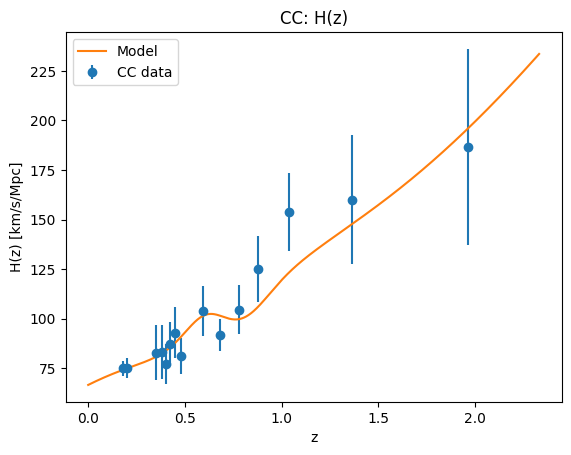

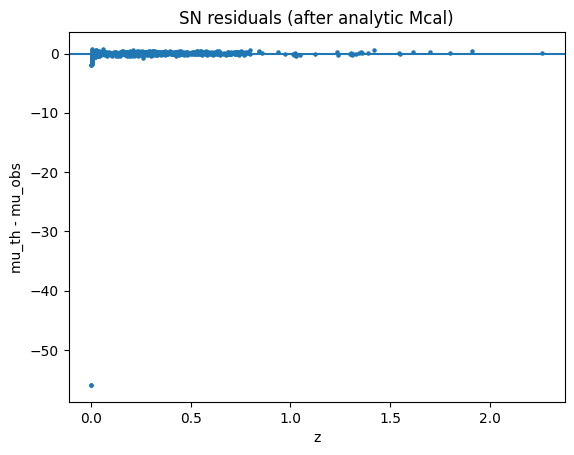

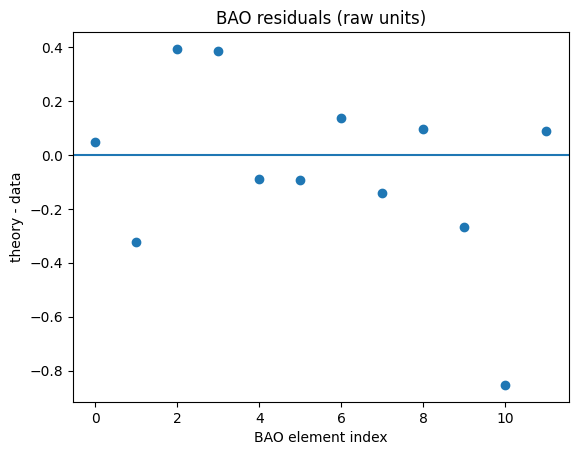


LOO CC influence (lowest H0_hat_drop):
     i  z_drop  H0_hat_drop
12  12  1.0370    66.469690
11  11  0.8754    66.588834
0    0  0.1791    66.677125
10  10  0.7812    66.795919
6    6  0.4497    66.826607
13  13  1.3630    66.874874
8    8  0.5929    66.878311
5    5  0.4247    66.908066
2    2  0.3519    66.918399
1    1  0.1993    66.934711

LOO CC influence (highest H0_hat_drop):
     i  z_drop  H0_hat_drop
13  13  1.3630    66.874874
8    8  0.5929    66.878311
5    5  0.4247    66.908066
2    2  0.3519    66.918399
1    1  0.1993    66.934711
3    3  0.3802    66.946045
14  14  1.9650    66.998400
4    4  0.4004    67.241372
7    7  0.4783    67.532488
9    9  0.6797    67.842014


In [ ]:
# cellule 14 - General

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.linalg import cho_factor, cho_solve

# -------------------------------------------------------
# 0) Guard: ensure Cell 11 ran
# -------------------------------------------------------
_required = ["res_best", "z_on_best", "Delta_best", "z_grid"]
missing = [k for k in _required if k not in globals()]
if missing:
    raise NameError(
        "Missing variables: "
        + ", ".join(missing)
        + ". Re-run Cell 11 (scan+refine) in the same kernel/session."
    )

c_km_s = 299792.458

# -------------------------------------------------------
# 1) Recompute nuisances (H0, rd, Mcal) + E(z)
# -------------------------------------------------------
def mu_from_E(z, E):
    order = np.argsort(z)
    z2 = z[order]
    E2 = E[order]
    invE = 1.0 / np.maximum(E2, 1e-12)
    chi = cumulative_trapezoid(invE, z2, initial=0.0)
    dL = (1.0 + z2) * np.maximum(chi, 1e-14)
    mu_star = 5.0 * np.log10(dL)
    out = np.empty_like(mu_star)
    out[order] = mu_star
    return out

def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

def best_s_from_BAO(bao, cf_bao, z_grid, E_grid):
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    Cinv_d = cho_solve(cf_bao, d, check_finite=False)
    Cinv_f = cho_solve(cf_bao, f, check_finite=False)
    return float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))

def recompute_nuisances(x, z_on, Delta):
    p7 = x[:7]; y0 = x[7]
    gfun = make_gfun(z_on, Delta)

    E_grid = model_E(z_grid, p7, y0, gfun)
    if E_grid is None or np.any(~np.isfinite(E_grid)):
        raise RuntimeError("model_E failed at best-fit parameters.")

    # SN
    E_sn = np.interp(z_sn, z_grid, E_grid)
    mu_star = mu_from_E(z_sn, E_sn)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)

    # CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)

    # BAO: infer rd effective via s_hat and H0
    s_hat = best_s_from_BAO(bao, cf_bao, z_grid, E_grid)
    rd = (c_km_s / H0) / s_hat

    return E_grid, H0, rd, Mcal

E_best, H0_best, rd_best, Mcal_best = recompute_nuisances(res_best.x, z_on_best, Delta_best)
print("H0_best   =", float(H0_best), "km/s/Mpc")
print("rd_best   =", float(rd_best), "Mpc (effective from CC+BAO)")
print("Mcal_best =", float(Mcal_best))

# -------------------------------------------------------
# 2) Basic plots
# -------------------------------------------------------
p7 = res_best.x[:7]
HD, _ = HD_and_dHD(z_grid, p7)

plt.figure()
plt.plot(z_grid, HD)
plt.xlabel("z"); plt.ylabel("H_D(z)")
plt.title("Best-fit H_D(z)")
plt.show()

plt.figure()
plt.plot(z_grid, E_best)
plt.xlabel("z"); plt.ylabel("E(z)")
plt.title("Best-fit E(z)=H(z)/H0")
plt.show()

plt.figure()
plt.errorbar(z_cc, H_cc, yerr=np.sqrt(np.diag(C_cc)), fmt="o", label="CC data")
plt.plot(z_grid, H0_best * E_best, label="Model")
plt.xlabel("z"); plt.ylabel("H(z) [km/s/Mpc]")
plt.title("CC: H(z)")
plt.legend()
plt.show()

# SN residuals
E_sn = np.interp(z_sn, z_grid, E_best)
mu_star = mu_from_E(z_sn, E_sn)
mu_th = mu_star + Mcal_best
plt.figure()
plt.scatter(z_sn, (mu_th - mu_sn), s=5)
plt.axhline(0)
plt.xlabel("z"); plt.ylabel("mu_th - mu_obs")
plt.title("SN residuals (after analytic Mcal)")
plt.show()

# BAO residuals (raw)
z_b = bao["z"].to_numpy(np.float64)
obs = bao["obs"].to_numpy()
d   = bao["val"].to_numpy(np.float64)
f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_best) for i in range(len(z_b))], dtype=np.float64)
s_hat = (c_km_s / H0_best) / rd_best
d_th = s_hat * f
r = d_th - d

plt.figure()
plt.scatter(np.arange(len(r)), r)
plt.axhline(0)
plt.xlabel("BAO element index"); plt.ylabel("theory - data")
plt.title("BAO residuals (raw units)")
plt.show()

# -------------------------------------------------------
# 3) LOO influence on CC (optional)
# -------------------------------------------------------
def loo_cc_influence(x, z_on, Delta):
    p7 = x[:7]; y0 = x[7]
    gfun = make_gfun(z_on, Delta)
    E_grid = model_E(z_grid, p7, y0, gfun)
    if E_grid is None:
        raise RuntimeError("model_E failed in LOO precompute.")

    Ecc_full = np.interp(z_cc, z_grid, E_grid)
    out = []

    for i in range(len(z_cc)):
        mask = np.ones(len(z_cc), dtype=bool)
        mask[i] = False

        # Diagonal CC cov by default, but keep generic
        C2 = C_cc[np.ix_(mask, mask)]
        cf2 = cho_factor(C2, lower=True, overwrite_a=False, check_finite=False)

        E2 = Ecc_full[mask]
        H2 = H_cc[mask]

        Cinv_H = cho_solve(cf2, H2, check_finite=False)
        Cinv_E = cho_solve(cf2, E2, check_finite=False)
        H0_hat = float(np.dot(E2, Cinv_H) / np.dot(E2, Cinv_E))
        out.append((i, float(z_cc[i]), H0_hat))

    return pd.DataFrame(out, columns=["i", "z_drop", "H0_hat_drop"])

df_loo = loo_cc_influence(res_best.x, z_on_best, Delta_best)
print("\nLOO CC influence (lowest H0_hat_drop):")
print(df_loo.sort_values("H0_hat_drop").head(10))
print("\nLOO CC influence (highest H0_hat_drop):")
print(df_loo.sort_values("H0_hat_drop").tail(10))


In [ ]:
# PARCIMONY/FLEXIBILITY

In [ ]:
# Cellule 1 - parsimony/flexibility

# ============================================================
# FIT flat ΛCDM on the SAME SN+CC+BAO likelihood (whitened)
# Requires from your notebook:
#   z_sn, mu_sn, cf_sn
#   z_cc, H_cc, cf_cc
#   bao (DataFrame with columns z,val,obs), cf_bao
#   bao_theory_factors(z, obs_label, z_grid, E_grid)
#   (optional) whiten(), otherwise defined here
# ============================================================

import numpy as np
from scipy.optimize import least_squares
from scipy.linalg import cho_solve, solve_triangular
from scipy.integrate import cumulative_trapezoid

# ---- checks
_required = ["z_sn","mu_sn","cf_sn","z_cc","H_cc","cf_cc","bao","cf_bao","bao_theory_factors"]
missing = [k for k in _required if k not in globals()]
if missing:
    raise NameError("Missing: " + ", ".join(missing) + " (run previous cells in same session).")

c_km_s = 299792.458

def _whiten(cf, r):
    c, lower = cf
    return solve_triangular(c, r, lower=lower, check_finite=False)

def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

def best_s_from_BAO(bao, cf_bao, z_grid, E_grid):
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    Cinv_d = cho_solve(cf_bao, d, check_finite=False)
    Cinv_f = cho_solve(cf_bao, f, check_finite=False)
    return float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))

def make_z_grid():
    zmax = float(max(z_sn.max(), z_cc.max(), bao["z"].max()))
    return np.linspace(0.0, zmax, 1500)

z_grid = make_z_grid()

def E_LCDM(z, Om):
    return np.sqrt(Om*(1.0+z)**3 + (1.0-Om))

Nsn, Ncc, Nbao = len(mu_sn), len(z_cc), len(bao)

def chi2_splits_for_Egrid(E_grid):
    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    # SN
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = _whiten(cf_sn, r_sn)

    # CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (H0*Ecc) - H_cc
    u_cc = _whiten(cf_cc, r_cc)

    # BAO
    s_hat = best_s_from_BAO(bao, cf_bao, z_grid, E_grid)
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (s_hat*f) - d
    u_bao = _whiten(cf_bao, r_bao)

    chi2_SN  = float(u_sn@u_sn)
    chi2_CC  = float(u_cc@u_cc)
    chi2_BAO = float(u_bao@u_bao)
    chi2_tot = chi2_SN + chi2_CC + chi2_BAO

    rd_eff = (c_km_s/H0)/s_hat

    return dict(H0=H0, s_hat=s_hat, rd_eff=rd_eff, Mcal=Mcal,
                chi2_SN=chi2_SN, chi2_CC=chi2_CC, chi2_BAO=chi2_BAO, chi2_tot=chi2_tot)

def residuals_LCDM(p):
    Om = float(p[0])
    if not (0.02 <= Om <= 0.98):
        return 1e6*np.ones(Nsn+Ncc+Nbao)
    E_grid = E_LCDM(z_grid, Om)
    out = chi2_splits_for_Egrid(E_grid)

    # Rebuild whitened residual vector for least_squares
    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0+z_sn)*np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)
    r_sn = (mu_star + out["Mcal"]) - mu_sn
    u_sn = _whiten(cf_sn, r_sn)

    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (out["H0"]*Ecc) - H_cc
    u_cc = _whiten(cf_cc, r_cc)

    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (out["s_hat"]*f) - d
    u_bao = _whiten(cf_bao, r_bao)

    return np.concatenate([u_sn, u_cc, u_bao])

# ---- fit Ωm
res_lcdm = least_squares(
    residuals_LCDM,
    x0=np.array([0.30], dtype=np.float64),
    bounds=(np.array([0.05]), np.array([0.60])),
    loss="soft_l1", f_scale=1.0,
    max_nfev=5000
)

Om_best = float(res_lcdm.x[0])
out_lcdm = chi2_splits_for_Egrid(E_LCDM(z_grid, Om_best))

print("=== flat ΛCDM (fit to SN+CC+BAO) ===")
print("Ωm =", Om_best)
print("H0 =", out_lcdm["H0"])
print("s_hat =", out_lcdm["s_hat"], "=> rd_eff =", out_lcdm["rd_eff"])
print("Mcal =", out_lcdm["Mcal"])
print("chi2_SN  =", out_lcdm["chi2_SN"],  "Nd=", Nsn,  "chi2/N=", out_lcdm["chi2_SN"]/Nsn)
print("chi2_CC  =", out_lcdm["chi2_CC"],  "Nd=", Ncc,  "chi2/N=", out_lcdm["chi2_CC"]/Ncc)
print("chi2_BAO =", out_lcdm["chi2_BAO"], "Nd=", Nbao, "chi2/N=", out_lcdm["chi2_BAO"]/Nbao)
print("chi2_tot =", out_lcdm["chi2_tot"], "Nd_tot=", Nsn+Ncc+Nbao)

# ---- compare to your ET_fractal baseline numbers (edit if you want exact)
ET = dict(H0=66.99094862079599, rd_eff=149.05070045363576, chi2_tot=1756.163699598619)
dchi2 = out_lcdm["chi2_tot"] - ET["chi2_tot"]
dH0_pct = 100.0*(out_lcdm["H0"] - ET["H0"])/ET["H0"]
drd_pct = 100.0*(out_lcdm["rd_eff"] - ET["rd_eff"])/ET["rd_eff"]

Ntot = Nsn+Ncc+Nbao
lnN = np.log(Ntot)

# parameter counts for "shape" only (nuisances solved analytically)
k_lcdm = 1
k_et_8  = 8          # x parameters only
k_et_10 = 10         # x + (z_on,Delta) if you count gating scan as parameters

AIC_lcdm = out_lcdm["chi2_tot"] + 2*k_lcdm
BIC_lcdm = out_lcdm["chi2_tot"] + k_lcdm*lnN

AIC_et8  = ET["chi2_tot"] + 2*k_et_8
BIC_et8  = ET["chi2_tot"] + k_et_8*lnN

AIC_et10 = ET["chi2_tot"] + 2*k_et_10
BIC_et10 = ET["chi2_tot"] + k_et_10*lnN

print("\n=== Δ vs ET_fractal baseline ===")
print("Δchi2_tot (ΛCDM - ET) =", dchi2)
print("ΔH0/H0_ET (%) =", dH0_pct)
print("Δrd/rd_ET (%) =", drd_pct)

print("\n=== Information criteria (shape params only) ===")
print("AIC:  ΛCDM =", AIC_lcdm, "| ET(k=8) =", AIC_et8, "| ET(k=10) =", AIC_et10)
print("BIC:  ΛCDM =", BIC_lcdm, "| ET(k=8) =", BIC_et8, "| ET(k=10) =", BIC_et10)


=== flat ΛCDM (fit to SN+CC+BAO) ===
Ωm = 0.316933755605435
H0 = 67.61932546894143
s_hat = 29.933834633174314 => rd_eff = 148.1110680254213
Mcal = 43.05819812477339
chi2_SN  = 1758.5118837738737 Nd= 1701 chi2/N= 1.0338106312603608
chi2_CC  = 6.166945536119723 Nd= 15 chi2/N= 0.4111297024079815
chi2_BAO = 15.040561609797548 Nd= 12 chi2/N= 1.2533801341497957
chi2_tot = 1779.719390919791 Nd_tot= 1728

=== Δ vs ET_fractal baseline ===
Δchi2_tot (ΛCDM - ET) = 23.555691321172162
ΔH0/H0_ET (%) = 0.938002612416163
Δrd/rd_ET (%) = -0.6304112797556006

=== Information criteria (shape params only) ===
AIC:  ΛCDM = 1781.719390919791 | ET(k=8) = 1772.163699598619 | ET(k=10) = 1776.163699598619
BIC:  ΛCDM = 1787.1741108691551 | ET(k=8) = 1815.801459193531 | ET(k=10) = 1830.7108990922588


In [ ]:
# ============================================================
# Cellule 2  — Parsimony/Flexibility (SN+CC+BAO) :
#   - Fit flat ΛCDM (Ωm) on SAME likelihood (whitened)
#   - Fit ET no-bump (H_hi,H_lo,zt,w,y0) on SAME likelihood
#   - AIC/BIC with "shape params only" (nuisances profiled analytically)
# ============================================================

import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.linalg import cho_solve, solve_triangular
from scipy.integrate import cumulative_trapezoid
from scipy.integrate import solve_ivp

# ---- checks
_required = ["z_sn","mu_sn","cf_sn","z_cc","H_cc","cf_cc","bao","cf_bao","bao_theory_factors"]
missing = [k for k in _required if k not in globals()]
if missing:
    raise NameError("Missing: " + ", ".join(missing) + " (run previous cells in same session).")

c_km_s = 299792.458

def _whiten(cf, r):
    c, lower = cf
    return solve_triangular(c, r, lower=lower, check_finite=False)

def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

def best_s_from_BAO(bao, cf_bao, z_grid, E_grid):
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    Cinv_d = cho_solve(cf_bao, d, check_finite=False)
    Cinv_f = cho_solve(cf_bao, f, check_finite=False)
    return float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))

def make_z_grid():
    zmax = float(max(z_sn.max(), z_cc.max(), bao["z"].max()))
    return np.linspace(0.0, zmax, 1500)

z_grid = make_z_grid()
Nsn, Ncc, Nbao = len(mu_sn), len(z_cc), len(bao)
Ntot = Nsn + Ncc + Nbao

# --------------------------
# Shared evaluator (chi2 splits) for any E_grid
# --------------------------
def chi2_splits_for_Egrid(E_grid):
    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    # SN
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = _whiten(cf_sn, r_sn)

    # CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (H0*Ecc) - H_cc
    u_cc = _whiten(cf_cc, r_cc)

    # BAO
    s_hat = best_s_from_BAO(bao, cf_bao, z_grid, E_grid)
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (s_hat*f) - d
    u_bao = _whiten(cf_bao, r_bao)

    chi2_SN  = float(u_sn@u_sn)
    chi2_CC  = float(u_cc@u_cc)
    chi2_BAO = float(u_bao@u_bao)
    chi2_tot = chi2_SN + chi2_CC + chi2_BAO

    rd_eff = (c_km_s/H0)/s_hat

    return dict(H0=H0, s_hat=s_hat, rd_eff=rd_eff, Mcal=Mcal,
                chi2_SN=chi2_SN, chi2_CC=chi2_CC, chi2_BAO=chi2_BAO, chi2_tot=chi2_tot)

# ============================================================
# 1) flat ΛCDM fit (Ωm)
# ============================================================
def E_LCDM(z, Om):
    return np.sqrt(Om*(1.0+z)**3 + (1.0-Om))

def residuals_LCDM(p):
    Om = float(p[0])
    if not (0.02 <= Om <= 0.98):
        return 1e6*np.ones(Ntot, dtype=np.float64)

    E_grid = E_LCDM(z_grid, Om)
    out = chi2_splits_for_Egrid(E_grid)

    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    # SN residual
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0+z_sn)*np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)
    r_sn = (mu_star + out["Mcal"]) - mu_sn
    u_sn = _whiten(cf_sn, r_sn)

    # CC residual
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (out["H0"]*Ecc) - H_cc
    u_cc = _whiten(cf_cc, r_cc)

    # BAO residual
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (out["s_hat"]*f) - d
    u_bao = _whiten(cf_bao, r_bao)

    return np.concatenate([u_sn, u_cc, u_bao])

res_lcdm = least_squares(
    residuals_LCDM,
    x0=np.array([0.30], dtype=np.float64),
    bounds=(np.array([0.05]), np.array([0.60])),
    loss="soft_l1", f_scale=1.0,
    max_nfev=5000
)

Om_best = float(res_lcdm.x[0])
out_lcdm = chi2_splits_for_Egrid(E_LCDM(z_grid, Om_best))

print("=== flat ΛCDM (fit to SN+CC+BAO) ===")
print("Ωm =", Om_best)
print("H0 =", out_lcdm["H0"])
print("s_hat =", out_lcdm["s_hat"], "=> rd_eff =", out_lcdm["rd_eff"])
print("Mcal =", out_lcdm["Mcal"])
print("chi2_SN  =", out_lcdm["chi2_SN"],  "Nd=", Nsn,  "chi2/N=", out_lcdm["chi2_SN"]/Nsn)
print("chi2_CC  =", out_lcdm["chi2_CC"],  "Nd=", Ncc,  "chi2/N=", out_lcdm["chi2_CC"]/Ncc)
print("chi2_BAO =", out_lcdm["chi2_BAO"], "Nd=", Nbao, "chi2/N=", out_lcdm["chi2_BAO"]/Nbao)
print("chi2_tot =", out_lcdm["chi2_tot"], "Nd_tot=", Ntot)

# ============================================================
# 2) ET no-bump fit on SAME SN+CC+BAO likelihood
#    x = [H_hi, H_lo, zt, w, y0]
#    gating g(z) is kept as in your pipeline (scan (z_on,Delta)),
#    but you may choose whether to count them as effective parameters.
# ============================================================

# ---- safe exp for stability
def _safe_exp(x):
    return np.exp(np.clip(x, -80, 80))

# ---- logistic sigmoide H_D(z) sans bump
def HD_and_dHD_A0(z, p4):
    H_hi, H_lo, zt, w = p4
    w = max(float(w), 1e-6)
    u = (z - zt)/w
    eu = _safe_exp(u)
    S = 1.0/(1.0 + eu)  # ~1 at small z if u<0 ; ~0 at large z if u>0
    dSdz = -(1.0/w) * S*(1.0 - S)
    HD  = H_hi + (H_lo - H_hi)*S
    dHD = (H_lo - H_hi)*dSdz
    return HD, dHD

# ---- gating (same functional form as before)
def make_gfun(z_on, Delta):
    Delta = max(float(Delta), 1e-4)
    z_on  = float(z_on)
    def g(z):
        return 1.0/(1.0 + _safe_exp((np.asarray(z) - z_on)/Delta))
    return g

# ---- dynamical mapping -> E(z) (same structure as your ET code)
gamma0 = float(globals().get("gamma0", 6.0))
t_star = float(globals().get("t_star", 1.0))

def solve_y_A0(z_grid, p4, y0, gfun):
    z0, z1 = float(z_grid[0]), float(z_grid[-1])
    def rhs(z, y):
        HD, dHD = HD_and_dHD_A0(z, p4)
        HD = max(float(HD), 1e-12)
        gz = float(gfun(z))
        return -gamma0/((1.0+z)*HD) - gz*y*(dHD/HD)
    sol = solve_ivp(rhs, (z0, z1), [float(y0)], t_eval=z_grid, rtol=1e-6, atol=1e-9)
    if not sol.success:
        return None
    return sol.y[0]

def model_E_A0(z_grid, p4, y0, gfun, zref_max=0.02):
    y = solve_y_A0(z_grid, p4, y0, gfun)
    if y is None:
        return None
    HD, dHD = HD_and_dHD_A0(z_grid, p4)
    if np.any(~np.isfinite(HD)) or np.any(HD <= 0):
        return None
    t = t_star * np.exp(y)
    denom = 1.0 + gfun(z_grid) * ((1.0+z_grid)/gamma0) * dHD * y
    if np.any(~np.isfinite(denom)) or np.any(np.abs(denom) < 1e-6):
        return None
    H = HD/(gamma0*t*denom)

    mref = (z_grid <= zref_max)
    if not np.any(mref):
        mref = (z_grid == z_grid.min())
    Href = float(np.mean(H[mref]))
    if not np.isfinite(Href) or abs(Href) < 1e-12:
        return None
    return H/Href

def residuals_ET_A0(x, z_on, Delta):
    # x=[H_hi,H_lo,zt,w,y0]
    p4 = x[:4]
    y0 = x[4]
    gfun = make_gfun(z_on, Delta)
    E_grid = model_E_A0(z_grid, p4, y0, gfun)
    if E_grid is None or np.any(~np.isfinite(E_grid)):
        return 1e6*np.ones(Ntot, dtype=np.float64)

    out = chi2_splits_for_Egrid(E_grid)

    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    # SN residual
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0+z_sn)*np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)
    r_sn = (mu_star + out["Mcal"]) - mu_sn
    u_sn = _whiten(cf_sn, r_sn)

    # CC residual
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (out["H0"]*Ecc) - H_cc
    u_cc = _whiten(cf_cc, r_cc)

    # BAO residual
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (out["s_hat"]*f) - d
    u_bao = _whiten(cf_bao, r_bao)

    return np.concatenate([u_sn, u_cc, u_bao])

# ---- bounds + init (adapt if needed)
zmax = float(z_grid[-1])
LB = np.array([3.0,  5.0, 0.00, 0.03, -50.0], dtype=np.float64)      # [H_hi,H_lo,zt,w,y0]
UB = np.array([6.5, 25.0, 1.20, 3.00,  50.0], dtype=np.float64)

X0 = np.array([5.8,  6.0, 0.05, 0.10,  5.0], dtype=np.float64)
X0 = np.clip(X0, LB+1e-9, UB-1e-9)

# ---- scan gating (z_on,Delta) like your previous method
ZON_GRID   = np.arange(0.55, 0.91, 0.05)
DELTA_GRID = np.array([0.05, 0.07, 0.10, 0.12, 0.15], dtype=np.float64)

best_cost = np.inf
best_pack = None
rows = []

for z_on in ZON_GRID:
    for Delta in DELTA_GRID:
        res = least_squares(
            lambda x: residuals_ET_A0(x, float(z_on), float(Delta)),
            X0,
            bounds=(LB, UB),
            loss="soft_l1", f_scale=1.0,
            max_nfev=2500
        )
        ok = bool(res.success) and np.isfinite(res.cost)
        cost = float(res.cost) if np.isfinite(res.cost) else np.inf
        rows.append({"z_on": float(z_on), "Delta": float(Delta), "success": ok, "cost": cost})
        if ok and cost < best_cost:
            best_cost = cost
            best_pack = (float(z_on), float(Delta), res)

df_scan = pd.DataFrame(rows).sort_values("cost")
print("\n=== ET no-bump (SN+CC+BAO) scan over (z_on,Delta) ===")
print(df_scan.head(10).to_string(index=False))

if best_pack is None:
    raise RuntimeError("ET no-bump scan failed: no successful solution found.")

z_on_best, Delta_best, res0 = best_pack

# refine from best
res_et = least_squares(
    lambda x: residuals_ET_A0(x, z_on_best, Delta_best),
    res0.x,
    bounds=(LB, UB),
    loss="soft_l1", f_scale=1.0,
    max_nfev=8000
)

x_et = res_et.x.copy()
p4_et, y0_et = x_et[:4], x_et[4]
E_et = model_E_A0(z_grid, p4_et, y0_et, make_gfun(z_on_best, Delta_best))
out_et = chi2_splits_for_Egrid(E_et)

print("\n=== ET no-bump (fit to SN+CC+BAO) ===")
print("z_on_best =", z_on_best, "Delta_best =", Delta_best)
print("x=[H_hi,H_lo,zt,w,y0] =", x_et)
print("H0 =", out_et["H0"])
print("s_hat =", out_et["s_hat"], "=> rd_eff =", out_et["rd_eff"])
print("Mcal =", out_et["Mcal"])
print("chi2_SN  =", out_et["chi2_SN"],  "Nd=", Nsn,  "chi2/N=", out_et["chi2_SN"]/Nsn)
print("chi2_CC  =", out_et["chi2_CC"],  "Nd=", Ncc,  "chi2/N=", out_et["chi2_CC"]/Ncc)
print("chi2_BAO =", out_et["chi2_BAO"], "Nd=", Nbao, "chi2/N=", out_et["chi2_BAO"]/Nbao)
print("chi2_tot =", out_et["chi2_tot"], "Nd_tot=", Ntot)

# ============================================================
# 3) AIC/BIC — include ET no-bump explicitly
# ============================================================
lnN = np.log(Ntot)

# "shape params only" (nuisances profiled analytically)
k_lcdm = 1
k_et_nobump = 5              # [H_hi,H_lo,zt,w,y0]
k_et_nobump_plus_gate = 7    # + (z_on,Delta) if counted as effective

AIC_lcdm = out_lcdm["chi2_tot"] + 2*k_lcdm
BIC_lcdm = out_lcdm["chi2_tot"] + k_lcdm*lnN

AIC_et5  = out_et["chi2_tot"] + 2*k_et_nobump
BIC_et5  = out_et["chi2_tot"] + k_et_nobump*lnN

AIC_et7  = out_et["chi2_tot"] + 2*k_et_nobump_plus_gate
BIC_et7  = out_et["chi2_tot"] + k_et_nobump_plus_gate*lnN

print("\n=== Information criteria (SN+CC+BAO | shape params only) ===")
print(f"N={Ntot} | lnN={lnN:.6f}")
print(f"AIC:  LCDM(k=1)={AIC_lcdm:.3f} | ET no-bump(k=5)={AIC_et5:.3f} | ET no-bump+(z_on,Δ)(k=7)={AIC_et7:.3f}")
print(f"BIC:  LCDM(k=1)={BIC_lcdm:.3f} | ET no-bump(k=5)={BIC_et5:.3f} | ET no-bump+(z_on,Δ)(k=7)={BIC_et7:.3f}")

dchi2 = out_lcdm["chi2_tot"] - out_et["chi2_tot"]
print("\nΔchi2_tot (LCDM - ET_no_bump) =", dchi2)

# Minimal table for your paper
tab = pd.DataFrame([
    {"model":"LCDM (SN+CC+BAO)", "k":k_lcdm, "chi2":out_lcdm["chi2_tot"], "AIC":AIC_lcdm, "BIC":BIC_lcdm, "H0":out_lcdm["H0"], "rd_eff":out_lcdm["rd_eff"]},
    {"model":"ET no-bump (SN+CC+BAO)", "k":k_et_nobump, "chi2":out_et["chi2_tot"], "AIC":AIC_et5, "BIC":BIC_et5, "H0":out_et["H0"], "rd_eff":out_et["rd_eff"]},
    {"model":"ET no-bump + gate counted", "k":k_et_nobump_plus_gate, "chi2":out_et["chi2_tot"], "AIC":AIC_et7, "BIC":BIC_et7, "H0":out_et["H0"], "rd_eff":out_et["rd_eff"]},
])
print("\n=== TABLE (minimal) ===")
print(tab.to_string(index=False))


=== flat ΛCDM (fit to SN+CC+BAO) ===
Ωm = 0.316933755605435
H0 = 67.61932546894143
s_hat = 29.933834633174314 => rd_eff = 148.1110680254213
Mcal = 43.05819812477339
chi2_SN  = 1758.5118837738737 Nd= 1701 chi2/N= 1.0338106312603608
chi2_CC  = 6.166945536119723 Nd= 15 chi2/N= 0.4111297024079815
chi2_BAO = 15.040561609797548 Nd= 12 chi2/N= 1.2533801341497957
chi2_tot = 1779.719390919791 Nd_tot= 1728

=== ET no-bump (SN+CC+BAO) scan over (z_on,Delta) ===
 z_on  Delta  success       cost
 0.55   0.15     True 581.400214
 0.60   0.15     True 581.569591
 0.55   0.12     True 581.583064
 0.90   0.15     True 581.599029
 0.90   0.05     True 581.627709
 0.90   0.07     True 581.631334
 0.90   0.12     True 581.644130
 0.90   0.10     True 581.647161
 0.85   0.15     True 581.658671
 0.85   0.05     True 581.672684

=== ET no-bump (fit to SN+CC+BAO) ===
z_on_best = 0.55 Delta_best = 0.15
x=[H_hi,H_lo,zt,w,y0] = [4.00447588e+00 6.51140859e+00 4.65421845e-06 5.82421531e-01
 3.90537000e-01]
H0 = 6

In [ ]:
# Cellule 3 - parsimony/flexibility

# ============================================================
# FIT flat ΛCDM on the SAME SN+CC+BAO likelihood (whitened)
# Requires from your notebook:
#   z_sn, mu_sn, cf_sn
#   z_cc, H_cc, cf_cc
#   bao (DataFrame with columns z,val,obs), cf_bao
#   bao_theory_factors(z, obs_label, z_grid, E_grid)
#   (optional) whiten(), otherwise defined here
# ============================================================

import numpy as np
from scipy.optimize import least_squares
from scipy.linalg import cho_solve, solve_triangular
from scipy.integrate import cumulative_trapezoid

# ---- checks
_required = ["z_sn","mu_sn","cf_sn","z_cc","H_cc","cf_cc","bao","cf_bao","bao_theory_factors"]
missing = [k for k in _required if k not in globals()]
if missing:
    raise NameError("Missing: " + ", ".join(missing) + " (run previous cells in same session).")

c_km_s = 299792.458

def _whiten(cf, r):
    c, lower = cf
    return solve_triangular(c, r, lower=lower, check_finite=False)

def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

def best_s_from_BAO(bao, cf_bao, z_grid, E_grid):
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    Cinv_d = cho_solve(cf_bao, d, check_finite=False)
    Cinv_f = cho_solve(cf_bao, f, check_finite=False)
    return float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))

def make_z_grid():
    zmax = float(max(z_sn.max(), z_cc.max(), bao["z"].max()))
    return np.linspace(0.0, zmax, 1500)

z_grid = make_z_grid()

def E_LCDM(z, Om):
    return np.sqrt(Om*(1.0+z)**3 + (1.0-Om))

Nsn, Ncc, Nbao = len(mu_sn), len(z_cc), len(bao)

def chi2_splits_for_Egrid(E_grid):
    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    # SN
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = _whiten(cf_sn, r_sn)

    # CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (H0*Ecc) - H_cc
    u_cc = _whiten(cf_cc, r_cc)

    # BAO
    s_hat = best_s_from_BAO(bao, cf_bao, z_grid, E_grid)
    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (s_hat*f) - d
    u_bao = _whiten(cf_bao, r_bao)

    chi2_SN  = float(u_sn@u_sn)
    chi2_CC  = float(u_cc@u_cc)
    chi2_BAO = float(u_bao@u_bao)
    chi2_tot = chi2_SN + chi2_CC + chi2_BAO

    rd_eff = (c_km_s/H0)/s_hat

    return dict(H0=H0, s_hat=s_hat, rd_eff=rd_eff, Mcal=Mcal,
                chi2_SN=chi2_SN, chi2_CC=chi2_CC, chi2_BAO=chi2_BAO, chi2_tot=chi2_tot)

def residuals_LCDM(p):
    Om = float(p[0])
    if not (0.02 <= Om <= 0.98):
        return 1e6*np.ones(Nsn+Ncc+Nbao)
    E_grid = E_LCDM(z_grid, Om)
    out = chi2_splits_for_Egrid(E_grid)

    # Rebuild whitened residual vector for least_squares
    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0+z_sn)*np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)
    r_sn = (mu_star + out["Mcal"]) - mu_sn
    u_sn = _whiten(cf_sn, r_sn)

    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (out["H0"]*Ecc) - H_cc
    u_cc = _whiten(cf_cc, r_cc)

    z_b = bao["z"].to_numpy(np.float64)
    obs = bao["obs"].to_numpy()
    d   = bao["val"].to_numpy(np.float64)
    f = np.array([bao_theory_factors(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)
    r_bao = (out["s_hat"]*f) - d
    u_bao = _whiten(cf_bao, r_bao)

    return np.concatenate([u_sn, u_cc, u_bao])

# ---- fit Ωm
res_lcdm = least_squares(
    residuals_LCDM,
    x0=np.array([0.30], dtype=np.float64),
    bounds=(np.array([0.05]), np.array([0.60])),
    loss="soft_l1", f_scale=1.0,
    max_nfev=5000
)

Om_best = float(res_lcdm.x[0])
out_lcdm = chi2_splits_for_Egrid(E_LCDM(z_grid, Om_best))

print("=== flat ΛCDM (fit to SN+CC+BAO) ===")
print("Ωm =", Om_best)
print("H0 =", out_lcdm["H0"])
print("s_hat =", out_lcdm["s_hat"], "=> rd_eff =", out_lcdm["rd_eff"])
print("Mcal =", out_lcdm["Mcal"])
print("chi2_SN  =", out_lcdm["chi2_SN"],  "Nd=", Nsn,  "chi2/N=", out_lcdm["chi2_SN"]/Nsn)
print("chi2_CC  =", out_lcdm["chi2_CC"],  "Nd=", Ncc,  "chi2/N=", out_lcdm["chi2_CC"]/Ncc)
print("chi2_BAO =", out_lcdm["chi2_BAO"], "Nd=", Nbao, "chi2/N=", out_lcdm["chi2_BAO"]/Nbao)
print("chi2_tot =", out_lcdm["chi2_tot"], "Nd_tot=", Nsn+Ncc+Nbao)

# ---- compare to your ET_fractal baseline numbers (edit if you want exact)
ET = dict(H0=66.99094862079599, rd_eff=149.05070045363576, chi2_tot=1756.163699598619)
dchi2 = out_lcdm["chi2_tot"] - ET["chi2_tot"]
dH0_pct = 100.0*(out_lcdm["H0"] - ET["H0"])/ET["H0"]
drd_pct = 100.0*(out_lcdm["rd_eff"] - ET["rd_eff"])/ET["rd_eff"]

Ntot = Nsn+Ncc+Nbao
lnN = np.log(Ntot)

# parameter counts for "shape" only (nuisances solved analytically)
k_lcdm = 1
k_et_8  = 4          # x parameters only
k_et_10 = 10         # x + (z_on,Delta) if you count gating scan as parameters

AIC_lcdm = out_lcdm["chi2_tot"] + 2*k_lcdm
BIC_lcdm = out_lcdm["chi2_tot"] + k_lcdm*lnN

AIC_et8  = ET["chi2_tot"] + 2*k_et_8
BIC_et8  = ET["chi2_tot"] + k_et_8*lnN

AIC_et10 = ET["chi2_tot"] + 2*k_et_10
BIC_et10 = ET["chi2_tot"] + k_et_10*lnN

print("\n=== Δ vs ET_fractal baseline ===")
print("Δchi2_tot (ΛCDM - ET) =", dchi2)
print("ΔH0/H0_ET (%) =", dH0_pct)
print("Δrd/rd_ET (%) =", drd_pct)

print("\n=== Information criteria (shape params only) ===")
print("AIC:  ΛCDM =", AIC_lcdm, "| ET(k=8) =", AIC_et8, "| ET(k=10) =", AIC_et10)
print("BIC:  ΛCDM =", BIC_lcdm, "| ET(k=8) =", BIC_et8, "| ET(k=10) =", BIC_et10)


=== flat ΛCDM (fit to SN+CC+BAO) ===
Ωm = 0.316933755605435
H0 = 67.61932546894143
s_hat = 29.933834633174314 => rd_eff = 148.1110680254213
Mcal = 43.05819812477339
chi2_SN  = 1758.5118837738737 Nd= 1701 chi2/N= 1.0338106312603608
chi2_CC  = 6.166945536119723 Nd= 15 chi2/N= 0.4111297024079815
chi2_BAO = 15.040561609797548 Nd= 12 chi2/N= 1.2533801341497957
chi2_tot = 1779.719390919791 Nd_tot= 1728

=== Δ vs ET_fractal baseline ===
Δchi2_tot (ΛCDM - ET) = 23.555691321172162
ΔH0/H0_ET (%) = 0.938002612416163
Δrd/rd_ET (%) = -0.6304112797556006

=== Information criteria (shape params only) ===
AIC:  ΛCDM = 1781.719390919791 | ET(k=8) = 1764.163699598619 | ET(k=10) = 1776.163699598619
BIC:  ΛCDM = 1787.1741108691551 | ET(k=8) = 1785.982579396075 | ET(k=10) = 1830.7108990922588


In [ ]:
# Cellule 4 - Annexe parsimony/flexibility
#============================================================
# REFIT theta under BAO ablations (drop-label / drop-point)
# Robust to existing LB/UB from other tests (e.g. no-bump 5D)
#
# Outputs:
#   - refit_bao_ablation_summary.csv
#   - refit_bao_ablation_params.csv
# ============================================================

import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.integrate import cumulative_trapezoid
from scipy.linalg import cho_solve, solve_triangular, cho_factor

# --------------------------
# 0) Guard rails
# --------------------------
_required = [
    "z_sn","mu_sn","cf_sn",
    "z_cc","H_cc","cf_cc",
    "bao","C_bao",
    "z_grid",
    "make_gfun","model_E",
    "z_on_best","Delta_best"
]
missing = [k for k in _required if k not in globals()]
if missing:
    raise NameError("Missing variables: " + ", ".join(missing) + " (run prior cells in same kernel).")

c_km_s = 299792.458

# --------------------------
# 1) Utilities
# --------------------------
def whiten(cf, r):
    c, lower = cf
    return solve_triangular(c, r, lower=lower, check_finite=False)

def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

def bao_factors_from_Egrid(z_b, obs, z_grid, E_grid):
    # f_i such that model prediction is: s_hat * f_i
    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)
    chi = np.interp(z_b, z_grid, chi_grid)
    E   = np.interp(z_b, z_grid, E_grid)

    obs = str(obs)
    if obs == "DM_over_rs":
        return chi
    if obs == "DH_over_rs":
        return 1.0/np.maximum(E, 1e-12)
    if obs == "DV_over_rs":
        return np.power(z_b * (chi**2) * (1.0/np.maximum(E,1e-12)), 1.0/3.0)

    raise ValueError(f"Unsupported BAO observable label: {obs}")

def best_s_from_BAO(bao_df, C_bao_sub, z_grid, E_grid):
    z_b = bao_df["z"].to_numpy(np.float64)
    obs = bao_df["obs"].astype(str).to_numpy()
    d   = bao_df["val"].to_numpy(np.float64)

    f = np.array([bao_factors_from_Egrid(z_b[i], obs[i], z_grid, E_grid) for i in range(len(z_b))],
                 dtype=np.float64)

    cf = cho_factor(C_bao_sub, overwrite_a=False, check_finite=False)
    Cinv_d = cho_solve(cf, d, check_finite=False)
    Cinv_f = cho_solve(cf, f, check_finite=False)
    s_hat = float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))
    return s_hat, f, d, cf

# --------------------------
# 2) E(z) from ET_fractal (bump model, 8 params)
# x = [H_hi, H_lo, zt, w, A, sigma, zb, y0]
# --------------------------
gfun_fixed = make_gfun(z_on_best, Delta_best)

def Egrid_from_x(x):
    p7 = x[:7]
    y0 = x[7]
    E = model_E(z_grid, p7, y0, gfun_fixed)
    if E is None or np.any(~np.isfinite(E)):
        return None
    return np.asarray(E, dtype=np.float64)

# --------------------------
# 3) Global residuals (whitened) for a BAO subset
# --------------------------
def residuals_global_for_bao_subset(x, bao_df_sub, C_bao_sub):
    E_grid = Egrid_from_x(x)
    if E_grid is None:
        return 1e6*np.ones(len(mu_sn) + len(z_cc) + len(bao_df_sub), dtype=np.float64)

    # ---- SN
    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)

    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = whiten(cf_sn, r_sn)

    # ---- CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (H0*Ecc) - H_cc
    u_cc = whiten(cf_cc, r_cc)

    # ---- BAO
    s_hat, f, d, cf_sub = best_s_from_BAO(bao_df_sub, C_bao_sub, z_grid, E_grid)
    r_bao = (s_hat * f) - d
    u_bao = whiten(cf_sub, r_bao)

    return np.concatenate([u_sn, u_cc, u_bao])

def diagnostics_for_bao_subset(x, bao_df_sub, C_bao_sub):
    E_grid = Egrid_from_x(x)
    if E_grid is None:
        return None

    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    # SN
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    u_sn = whiten(cf_sn, (mu_star + Mcal) - mu_sn)
    chi2_SN = float(u_sn @ u_sn)

    # CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    u_cc = whiten(cf_cc, (H0*Ecc) - H_cc)
    chi2_CC = float(u_cc @ u_cc)

    # BAO
    s_hat, f, d, cf_sub = best_s_from_BAO(bao_df_sub, C_bao_sub, z_grid, E_grid)
    u_bao = whiten(cf_sub, (s_hat*f) - d)
    chi2_BAO = float(u_bao @ u_bao)

    rd_eff = (c_km_s/H0)/s_hat
    chi2_tot = chi2_SN + chi2_CC + chi2_BAO

    return dict(
        H0=float(H0), s_hat=float(s_hat), rd_eff=float(rd_eff), Mcal=float(Mcal),
        chi2_SN=float(chi2_SN), chi2_CC=float(chi2_CC), chi2_BAO=float(chi2_BAO), chi2_tot=float(chi2_tot),
        Nsn=int(len(mu_sn)), Ncc=int(len(z_cc)), Nbao=int(len(bao_df_sub)),
        Ntot=int(len(mu_sn)+len(z_cc)+len(bao_df_sub)),
    )

# --------------------------
# 4) BAO subsets
# --------------------------
bao_df = bao.copy().reset_index(drop=True)
C_bao = np.asarray(C_bao, dtype=np.float64)
Nbao_full = len(bao_df)
if C_bao.shape != (Nbao_full, Nbao_full):
    raise ValueError(f"C_bao shape {C_bao.shape} != ({Nbao_full},{Nbao_full}).")

def subset_by_indices(keep_idx):
    keep_idx = np.array(keep_idx, dtype=int)
    sub_df = bao_df.iloc[keep_idx].reset_index(drop=True)
    sub_C  = C_bao[np.ix_(keep_idx, keep_idx)]
    return sub_df, sub_C

# Labels
labels = sorted(pd.unique(bao_df["obs"].astype(str)))

# Influential indices from your LOO:
drop_points = [3, 1, 10]

suite = [("FULL", "full_BAO", np.arange(Nbao_full))]
for lab in labels:
    keep = np.where(bao_df["obs"].astype(str).to_numpy() != lab)[0]
    if len(keep) >= 2:
        suite.append(("DROP_label", f"drop_{lab}", keep))
for i in drop_points:
    keep = np.array([j for j in range(Nbao_full) if j != int(i)], dtype=int)
    suite.append(("DROP_point", f"drop_i{i}_z{bao_df.loc[i,'z']}_{bao_df.loc[i,'obs']}", keep))

# --------------------------
# 5) Bounds and x0 (FORCE 8D)
# --------------------------
D = 8

LB_default = np.array([3.5, 6.0, 0.0, 0.05, 0.0, 0.08, 0.0, -50.0], dtype=np.float64)
UB_default = np.array([6.0, 25.0, 1.2, 0.50, 20.0, 0.60, float(z_grid[-1]),  50.0], dtype=np.float64)

use_globals_bounds = False
if "LB" in globals() and "UB" in globals():
    LB_g = np.asarray(LB, dtype=np.float64).ravel()
    UB_g = np.asarray(UB, dtype=np.float64).ravel()
    if LB_g.shape[0] == D and UB_g.shape[0] == D:
        LB_use, UB_use = LB_g, UB_g
        use_globals_bounds = True
    else:
        LB_use, UB_use = LB_default, UB_default
else:
    LB_use, UB_use = LB_default, UB_default

if not use_globals_bounds:
    print("Note: using default 8D bounds (existing LB/UB not 8D, likely from no-bump test).")

# x0
if "res_best" in globals() and hasattr(res_best, "x") and np.asarray(res_best.x).shape[0] == D:
    X0 = np.asarray(res_best.x, dtype=np.float64).copy()
else:
    X0 = np.array([4.5, 8.0, 0.65, 0.30, 0.3, 0.15, 0.7, 0.0], dtype=np.float64)

if X0.shape[0] != D:
    raise ValueError(f"X0 has dim {X0.shape[0]} but expected {D} (bump model).")

MAX_NFEV = 6000

# --------------------------
# 6) Fit runner
# --------------------------
def run_fit(tag, bao_keep_idx):
    bao_sub_df, C_sub = subset_by_indices(bao_keep_idx)

    fun = lambda x: residuals_global_for_bao_subset(x, bao_sub_df, C_sub)
    res = least_squares(
        fun, X0,
        bounds=(LB_use, UB_use),
        loss="soft_l1", f_scale=1.0,
        max_nfev=MAX_NFEV
    )

    diag = diagnostics_for_bao_subset(res.x, bao_sub_df, C_sub)
    if diag is None:
        raise RuntimeError("Diagnostics failed (E_grid invalid).")

    # bound hits
    hits = []
    eps = 1e-12
    for k in range(D):
        if abs(res.x[k] - LB_use[k]) <= eps*(1+abs(LB_use[k])):
            hits.append((k, "LOWER", float(LB_use[k])))
        if abs(res.x[k] - UB_use[k]) <= eps*(1+abs(UB_use[k])):
            hits.append((k, "UPPER", float(UB_use[k])))

    row = {
        "tag": tag,
        "success": bool(res.success),
        "cost": float(res.cost),
        "chi2_tot": float(diag["chi2_tot"]),
        "chi2_SN": float(diag["chi2_SN"]),
        "chi2_CC": float(diag["chi2_CC"]),
        "chi2_BAO": float(diag["chi2_BAO"]),
        "H0": float(diag["H0"]),
        "rd_eff": float(diag["rd_eff"]),
        "s_hat": float(diag["s_hat"]),
        "Mcal": float(diag["Mcal"]),
        "Nbao": int(diag["Nbao"]),
        "Ntot": int(diag["Ntot"]),
        "n_hits": int(len(hits)),
        "hits": str(hits),
    }

    params = {
        "tag": tag,
        "H_hi": float(res.x[0]),
        "H_lo": float(res.x[1]),
        "zt": float(res.x[2]),
        "w": float(res.x[3]),
        "A": float(res.x[4]),
        "sigma": float(res.x[5]),
        "zb": float(res.x[6]),
        "y0": float(res.x[7]),
    }

    return row, params, res

# --------------------------
# 7) Run suite
# --------------------------
summary_rows = []
param_rows = []
res_store = {}

print("=== REFIT suite (BAO ablations) ===")
for mode, name, keep_idx in suite:
    tag = f"{mode}:{name}"
    row, par, res = run_fit(tag, keep_idx)

    summary_rows.append(row)
    param_rows.append(par)
    res_store[tag] = res

    print(f"\n[{tag}]")
    print(" success =", row["success"], "chi2_tot =", row["chi2_tot"], "chi2_BAO =", row["chi2_BAO"])
    print(" H0 =", row["H0"], "rd_eff =", row["rd_eff"], "Nbao =", row["Nbao"])
    if row["n_hits"] > 0:
        print(" bound hits:", row["hits"])

df_sum = pd.DataFrame(summary_rows)
df_par = pd.DataFrame(param_rows)

# Δχ² relative to FULL run in this cell
full_row = df_sum[df_sum["tag"]=="FULL:full_BAO"]
if len(full_row) != 1:
    raise RuntimeError("FULL run not found uniquely in summary.")
full_chi2 = float(full_row["chi2_tot"].iloc[0])
full_chi2_bao = float(full_row["chi2_BAO"].iloc[0])

df_sum["Delta_chi2_vs_FULL"] = df_sum["chi2_tot"] - full_chi2
df_sum["Delta_chi2BAO_vs_FULL"] = df_sum["chi2_BAO"] - full_chi2_bao

df_sum = df_sum.sort_values("chi2_tot")
df_sum.to_csv("refit_bao_ablation_summary.csv", index=False)
df_par.to_csv("refit_bao_ablation_params.csv", index=False)

print("\n=== Sorted summary (best chi2_tot first) ===")
print(df_sum[["tag","chi2_tot","Delta_chi2_vs_FULL","chi2_BAO","Delta_chi2BAO_vs_FULL","H0","rd_eff","Nbao","n_hits"]].head(20))

print("\nSaved:")
print(" - refit_bao_ablation_summary.csv")
print(" - refit_bao_ablation_params.csv")


Note: using default 8D bounds (existing LB/UB not 8D, likely from no-bump test).
=== REFIT suite (BAO ablations) ===

[FULL:full_BAO]
 success = True chi2_tot = 1755.5711648608371 chi2_BAO = 4.836239525994191
 H0 = 66.86496920614144 rd_eff = 149.0013283812992 Nbao = 12

[DROP_label:drop_DH_over_rs]
 success = True chi2_tot = 1753.2001209735722 chi2_BAO = 3.8739553639261755
 H0 = 67.24599839563255 rd_eff = 148.1946987115268 Nbao = 7

[DROP_label:drop_DM_over_rs]
 success = True chi2_tot = 1750.9012168678703 chi2_BAO = 0.9459685888081069
 H0 = 66.98084683732822 rd_eff = 150.11810619673997 Nbao = 7

[DROP_label:drop_DV_over_rs]
 success = True chi2_tot = 1755.14811001344 chi2_BAO = 4.371395441993773
 H0 = 66.68029290713505 rd_eff = 148.6735580641378 Nbao = 10

[DROP_point:drop_i3_z0.706_DM_over_rs]
 success = True chi2_tot = 1753.207954525607 chi2_BAO = 2.934874385474924
 H0 = 66.8727803573985 rd_eff = 148.1886843572846 Nbao = 11

[DROP_point:drop_i1_z0.51_DM_over_rs]
 success = True chi2

In [ ]:
# TEST SIGNATURE

In [ ]:
# ============================================================
# Cellule 1 — REFIT suite (BAO ablations) for flat ΛCDM
# Model: E(z) = sqrt(Ωm (1+z)^3 + (1-Ωm))
#
# Outputs:
#   - lcdm_refit_bao_ablation_summary.csv
#   - lcdm_refit_bao_ablation_params.csv
# ============================================================

import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.integrate import cumulative_trapezoid
from scipy.linalg import cho_solve, solve_triangular, cho_factor

# --------------------------
# 0) Guard rails
# --------------------------
_required = [
    "z_sn","mu_sn","cf_sn",
    "z_cc","H_cc","cf_cc",
    "bao","C_bao",
    "z_grid"
]
missing = [k for k in _required if k not in globals()]
if missing:
    raise NameError("Missing variables: " + ", ".join(missing))

c_km_s = 299792.458

# --------------------------
# 1) Utilities
# --------------------------
def whiten(cf, r):
    c, lower = cf
    return solve_triangular(c, r, lower=lower, check_finite=False)

def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

def bao_factors_from_Egrid(z_b, obs, z_grid, E_grid):
    invE = 1.0 / np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)
    chi = np.interp(z_b, z_grid, chi_grid)
    E   = np.interp(z_b, z_grid, E_grid)

    obs = str(obs)
    if obs == "DM_over_rs":
        return chi
    if obs == "DH_over_rs":
        return 1.0 / np.maximum(E, 1e-12)
    if obs == "DV_over_rs":
        return np.power(z_b * (chi**2) * (1.0/np.maximum(E,1e-12)), 1.0/3.0)

    raise ValueError(f"Unsupported BAO observable label: {obs}")

def best_s_from_BAO(bao_df, C_bao_sub, z_grid, E_grid):
    z_b = bao_df["z"].to_numpy(np.float64)
    obs = bao_df["obs"].astype(str).to_numpy()
    d   = bao_df["val"].to_numpy(np.float64)

    f = np.array(
        [bao_factors_from_Egrid(z_b[i], obs[i], z_grid, E_grid)
         for i in range(len(z_b))],
        dtype=np.float64
    )

    cf = cho_factor(C_bao_sub, overwrite_a=False, check_finite=False)
    Cinv_d = cho_solve(cf, d, check_finite=False)
    Cinv_f = cho_solve(cf, f, check_finite=False)
    s_hat = float(np.dot(f, Cinv_d) / np.dot(f, Cinv_f))
    return s_hat, f, d, cf

# --------------------------
# 2) ΛCDM E(z)
# --------------------------
def E_lcdm(z, Om):
    return np.sqrt(Om*(1+z)**3 + (1.0-Om))

def Egrid_from_x_lcdm(x):
    Om = x[0]
    if Om <= 0 or Om >= 1:
        return None
    return E_lcdm(z_grid, Om)

# --------------------------
# 3) Global residuals (ΛCDM)
# --------------------------
def residuals_global_lcdm(x, bao_df_sub, C_bao_sub):
    E_grid = Egrid_from_x_lcdm(x)
    if E_grid is None or np.any(~np.isfinite(E_grid)):
        return 1e6*np.ones(len(mu_sn)+len(z_cc)+len(bao_df_sub))

    # ---- SN
    invE = 1.0/np.maximum(E_grid,1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0+z_sn)*np.maximum(chi_sn,1e-14)
    mu_star = 5.0*np.log10(dL_sn)

    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    u_sn = whiten(cf_sn, (mu_star+Mcal)-mu_sn)

    # ---- CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    u_cc = whiten(cf_cc, (H0*Ecc)-H_cc)

    # ---- BAO
    s_hat, f, d, cf_sub = best_s_from_BAO(bao_df_sub, C_bao_sub, z_grid, E_grid)
    u_bao = whiten(cf_sub, (s_hat*f)-d)

    return np.concatenate([u_sn,u_cc,u_bao])

def diagnostics_lcdm(x, bao_df_sub, C_bao_sub):
    E_grid = Egrid_from_x_lcdm(x)
    invE = 1.0/np.maximum(E_grid,1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)

    # SN
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0+z_sn)*np.maximum(chi_sn,1e-14)
    mu_star = 5.0*np.log10(dL_sn)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    u_sn = whiten(cf_sn, (mu_star+Mcal)-mu_sn)
    chi2_SN = float(u_sn@u_sn)

    # CC
    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    u_cc = whiten(cf_cc, (H0*Ecc)-H_cc)
    chi2_CC = float(u_cc@u_cc)

    # BAO
    s_hat, f, d, cf_sub = best_s_from_BAO(bao_df_sub, C_bao_sub, z_grid, E_grid)
    u_bao = whiten(cf_sub, (s_hat*f)-d)
    chi2_BAO = float(u_bao@u_bao)

    rd_eff = (c_km_s/H0)/s_hat
    chi2_tot = chi2_SN+chi2_CC+chi2_BAO

    return dict(
        Om=float(x[0]), H0=float(H0), rd_eff=float(rd_eff), Mcal=float(Mcal),
        chi2_SN=chi2_SN, chi2_CC=chi2_CC, chi2_BAO=chi2_BAO,
        chi2_tot=chi2_tot, Nbao=len(bao_df_sub)
    )

# --------------------------
# 4) BAO subsets
# --------------------------
bao_df = bao.copy().reset_index(drop=True)
C_bao = np.asarray(C_bao,float)
Nbao = len(bao_df)

def subset(keep_idx):
    keep_idx = np.array(keep_idx,int)
    return bao_df.iloc[keep_idx].reset_index(drop=True), C_bao[np.ix_(keep_idx,keep_idx)]

labels = sorted(pd.unique(bao_df["obs"].astype(str)))
drop_points = [3,1,10]

suite = [("FULL","full_BAO",np.arange(Nbao))]
for lab in labels:
    keep = np.where(bao_df["obs"].astype(str)!=lab)[0]
    if len(keep)>=2:
        suite.append(("DROP_label",f"drop_{lab}",keep))
for i in drop_points:
    suite.append(("DROP_point",f"drop_i{i}_z{bao_df.loc[i,'z']}_{bao_df.loc[i,'obs']}",
                  [j for j in range(Nbao) if j!=i]))

# --------------------------
# 5) Fit
# --------------------------
LB = np.array([0.05])
UB = np.array([0.6])
X0 = np.array([0.3])

rows, pars = [], []

print("=== REFIT suite ΛCDM (BAO ablations) ===")
for mode,name,keep in suite:
    bao_sub,C_sub = subset(keep)
    res = least_squares(
        lambda x: residuals_global_lcdm(x,bao_sub,C_sub),
        X0,bounds=(LB,UB),loss="soft_l1",max_nfev=4000
    )
    diag = diagnostics_lcdm(res.x,bao_sub,C_sub)

    row = dict(tag=f"{mode}:{name}",**diag)
    rows.append(row)
    pars.append({"tag":row["tag"],"Om":diag["Om"]})

    print(f"\n[{row['tag']}] chi2_tot={diag['chi2_tot']:.3f} "
          f"chi2_BAO={diag['chi2_BAO']:.3f} H0={diag['H0']:.3f}")

df_sum = pd.DataFrame(rows).sort_values("chi2_tot")
df_par = pd.DataFrame(pars)

df_sum.to_csv("lcdm_refit_bao_ablation_summary.csv",index=False)
df_par.to_csv("lcdm_refit_bao_ablation_params.csv",index=False)

print("\nSaved:")
print(" - lcdm_refit_bao_ablation_summary.csv")
print(" - lcdm_refit_bao_ablation_params.csv")


=== REFIT suite ΛCDM (BAO ablations) ===

[FULL:full_BAO] chi2_tot=1783.682 chi2_BAO=18.532 H0=67.681

[DROP_label:drop_DH_over_rs] chi2_tot=1768.985 chi2_BAO=7.742 H0=67.068

[DROP_label:drop_DM_over_rs] chi2_tot=1771.684 chi2_BAO=9.156 H0=67.302

[DROP_label:drop_DV_over_rs] chi2_tot=1783.136 chi2_BAO=18.522 H0=67.611

[DROP_point:drop_i3_z0.706_DM_over_rs] chi2_tot=1781.239 chi2_BAO=17.186 H0=67.534

[DROP_point:drop_i1_z0.51_DM_over_rs] chi2_tot=1778.142 chi2_BAO=14.493 H0=67.476

[DROP_point:drop_i10_z2.33_DM_over_rs] chi2_tot=1781.457 chi2_BAO=16.726 H0=67.626

Saved:
 - lcdm_refit_bao_ablation_summary.csv
 - lcdm_refit_bao_ablation_params.csv


In [ ]:
# Cellule 2 - Test signature

import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import least_squares
from scipy.linalg import solve_triangular, cho_factor
from scipy.integrate import solve_ivp

c_km_s = 299792.458

def whiten(cf, r):
    c, lower = cf
    return solve_triangular(c, r, lower=lower, check_finite=False)

def profiled_offset_from_whitened(u_d, w_ones):
    # minimize ||u_d + M*w||^2  =>  M = -(w·u_d)/(w·w)
    denom = float(np.dot(w_ones, w_ones))
    return -float(np.dot(w_ones, u_d)) / denom

def profiled_scale_from_whitened(w_f, w_d):
    # minimize ||s*w_f - w_d||^2 => s = (w_f·w_d)/(w_f·w_f)
    denom = float(np.dot(w_f, w_f))
    return float(np.dot(w_f, w_d)) / denom

def chi_grid_from_E(z_grid, E_grid):
    invE = 1.0 / np.maximum(E_grid, 1e-12)
    return cumulative_trapezoid(invE, z_grid, initial=0.0)

def bao_theory_factor(z_b, obs, z_grid, E_grid, chi_grid):
    obs = str(obs).strip()
    chi = np.interp(z_b, z_grid, chi_grid)
    E   = np.interp(z_b, z_grid, E_grid)

    if obs == "DM_over_rs":
        return chi
    if obs == "DH_over_rs":
        return 1.0 / np.maximum(E, 1e-12)
    if obs == "DV_over_rs":
        return np.power(z_b * (chi**2) * (1.0/np.maximum(E,1e-12)), 1.0/3.0)
    raise ValueError(f"Unsupported BAO obs label: {obs}")

def bao_predicted_chi2(E_grid, z_grid, bao_df, cf_bao):
    chi_grid = chi_grid_from_E(z_grid, E_grid)

    z_b = bao_df["z"].to_numpy(np.float64)
    d   = bao_df["val"].to_numpy(np.float64)
    obs = bao_df["obs"].astype(str).to_numpy()

    f = np.array([bao_theory_factor(z_b[i], obs[i], z_grid, E_grid, chi_grid)
                  for i in range(len(z_b))], dtype=np.float64)

    w_f = whiten(cf_bao, f)
    w_d = whiten(cf_bao, d)
    s_hat = profiled_scale_from_whitened(w_f, w_d)

    u_bao = s_hat*w_f - w_d
    chi2  = float(u_bao @ u_bao)
    return chi2, s_hat

# --- Guard: variables attendues ---
_required = ["z_grid", "z_sn", "mu_sn", "cf_sn", "z_cc", "H_cc", "cf_cc", "bao", "C_bao"]
missing = [k for k in _required if k not in globals()]
if missing:
    raise NameError("Missing variables in kernel: " + ", ".join(missing))

# Precompute whitened ones for SN (pour Mcal profilé)
ones_sn  = np.ones_like(mu_sn, dtype=np.float64)
w1_sn    = whiten(cf_sn, ones_sn)

# Precompute BAO Cholesky once
cf_bao_full = cho_factor(np.asarray(C_bao, float), overwrite_a=False, check_finite=False)

print("OK Cell 1.  SN N=", len(mu_sn), "CC N=", len(z_cc), "BAO N=", len(bao))


OK Cell 1.  SN N= 1701 CC N= 15 BAO N= 12


In [ ]:
# Cellule 3 - Test signature

def E_lcdm(z, Om):
    return np.sqrt(Om*(1.0+z)**3 + (1.0-Om))

def residuals_SNCC_lcdm(x):
    Om = float(x[0])
    if not (0.02 < Om < 0.8):
        return 1e6*np.ones(len(mu_sn)+len(z_cc))

    E_grid = E_lcdm(z_grid, Om)
    chi_grid = chi_grid_from_E(z_grid, E_grid)

    # --- SN ---
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn  = (1.0+z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)

    u_d = whiten(cf_sn, (mu_star - mu_sn))
    Mcal = profiled_offset_from_whitened(u_d, w1_sn)
    u_sn = u_d + Mcal*w1_sn

    # --- CC (H(z)=H0*E(z), H0 profilé) ---
    Ecc = np.interp(z_cc, z_grid, E_grid)
    w_E = whiten(cf_cc, Ecc)
    w_H = whiten(cf_cc, H_cc)
    H0  = profiled_scale_from_whitened(w_E, w_H)
    u_cc = H0*w_E - w_H

    return np.concatenate([u_sn, u_cc])

# Fit
LB = np.array([0.05])
UB = np.array([0.6])
X0 = np.array([0.3])

res_lcdm = least_squares(
    residuals_SNCC_lcdm, X0, bounds=(LB,UB),
    loss="linear", max_nfev=4000
)

Om_best = float(res_lcdm.x[0])
E_lcdm_best = E_lcdm(z_grid, Om_best)

# Diagnostics SN+CC
u_all = residuals_SNCC_lcdm(res_lcdm.x)
chi2_SNCC = float(u_all@u_all)

# BAO predicted (no BAO in fit)
chi2_BAO_pred, s_hat = bao_predicted_chi2(E_lcdm_best, z_grid, bao, cf_bao_full)

# derive H0 from CC (for rd_eff)
Ecc = np.interp(z_cc, z_grid, E_lcdm_best)
w_E = whiten(cf_cc, Ecc)
w_H = whiten(cf_cc, H_cc)
H0_best = profiled_scale_from_whitened(w_E, w_H)
rd_eff = (c_km_s/H0_best)/s_hat

print("=== ΛCDM train: SN+CC only ===")
print("Ωm =", Om_best)
print("chi2_SNCC =", chi2_SNCC, "Nd_SNCC =", (len(mu_sn)+len(z_cc)))
print("--- BAO predicted ---")
print("chi2_BAO_pred =", chi2_BAO_pred, "Nd_BAO =", len(bao))
print("H0(CC) =", H0_best, "s_hat =", s_hat, "=> rd_eff =", rd_eff)


=== ΛCDM train: SN+CC only ===
Ωm = 0.3603996971730042
chi2_SNCC = 1758.7138884825995 Nd_SNCC = 1716
--- BAO predicted ---
chi2_BAO_pred = 32.60626136953842 Nd_BAO = 12
H0(CC) = 66.04021622324744 s_hat = 30.7107621854831 => rd_eff = 147.81605977517023


In [ ]:
# Cellule 4 - Test signature

# --------------------------
# ET_fractal model (E(z) via ODE, gating+bump)
# --------------------------
gamma0 = 6.0
t_star = 1.0

def HD_and_dHD(z, p7):
    # p7 = [H_hi, H_lo, zt, w, A, sig, zb]
    H_hi, H_lo, zt, w, A, sig, zb = [float(v) for v in p7]

    # Sigmoid centered at zt
    u = (z - zt) / max(w, 1e-6)
    S = 1.0 / (1.0 + np.exp(u))
    dSdz = -(1.0 / max(w, 1e-6)) * S * (1.0 - S)

    # Gaussian bump centered at zb
    sig = max(sig, 1e-6)
    G = np.exp(-0.5 * ((z - zb) / sig) ** 2)
    dGdz = G * (-(z - zb) / (sig ** 2))

    HD  = H_hi + (H_lo - H_hi) * S + A * G
    dHD = (H_lo - H_hi) * dSdz + A * dGdz
    return HD, dHD

def make_gfun(z_on, Delta):
    Delta = max(float(Delta), 1e-6)
    z_on  = float(z_on)
    def g(z):
        return 1.0 / (1.0 + np.exp((z - z_on)/Delta))
    return g

def solve_y(z_grid, p7, y0, gfun):
    def rhs(z, y):
        HD, dHD = HD_and_dHD(z, p7)
        HD = np.maximum(HD, 1e-12)
        gz = gfun(z)
        return -gamma0 / ((1.0 + z) * HD) - gz * y * (dHD / HD)

    sol = solve_ivp(rhs, (float(z_grid[0]), float(z_grid[-1])), [float(y0)],
                    t_eval=z_grid, rtol=1e-6, atol=1e-9)
    if not sol.success:
        return None
    return sol.y[0]

def model_E_ET(z_grid, p7, y0, gfun):
    y = solve_y(z_grid, p7, y0, gfun)
    if y is None:
        return None

    HD, dHD = HD_and_dHD(z_grid, p7)
    if np.any(~np.isfinite(HD)) or np.any(HD <= 0):
        return None

    t = t_star * np.exp(y)
    denom = 1.0 + gfun(z_grid) * ((1.0 + z_grid) / gamma0) * dHD * y
    if np.any(~np.isfinite(denom)) or np.any(np.abs(denom) < 1e-6):
        return None

    H = HD / (gamma0 * t * denom)

    # Normalize to E(z)=H/Href on very low-z window
    mref = (z_grid >= 0.0) & (z_grid <= 0.02)
    if not np.any(mref):
        mref = (z_grid >= z_grid.min()) & (z_grid <= z_grid.min()+0.02)
    Href = float(np.mean(H[mref]))
    return H / max(Href, 1e-12)

# --------------------------
# Fit SN+CC only (with gating scan or freeze)
# --------------------------
GATING_MODE = "scan"   # "scan" or "freeze"
ZON_GRID   = np.arange(0.55, 0.91, 0.05)
DELTA_GRID = np.array([0.05, 0.07, 0.10, 0.12, 0.15])

# freeze values (used only if GATING_MODE="freeze")
ZON_FREEZE   = 0.70
DELTA_FREEZE = 0.15

# Bounds for x = [H_hi,H_lo,zt,w,A,sig,zb,y0]
LB = np.array([3.0, 5.0, 0.00, 0.03, 0.0, 0.08, 0.00, -50.0])
UB = np.array([6.0, 25.0, 1.20, 2.00, 5.0, 0.60, float(np.max(z_grid)), 50.0])

X0 = np.array([4.0, 6.5, 0.65, 0.40, 0.2, 0.14, 0.72, -0.15])

def residuals_SNCC_ET(x, z_on, Delta):
    p7 = x[:7]
    y0 = float(x[7])
    gfun = make_gfun(z_on, Delta)

    E_grid = model_E_ET(z_grid, p7, y0, gfun)
    if E_grid is None or np.any(~np.isfinite(E_grid)):
        return 1e6*np.ones(len(mu_sn)+len(z_cc))

    chi_grid = chi_grid_from_E(z_grid, E_grid)

    # --- SN ---
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn  = (1.0+z_sn) * np.maximum(chi_sn, 1e-14)
    mu_star = 5.0*np.log10(dL_sn)

    u_d = whiten(cf_sn, (mu_star - mu_sn))
    Mcal = profiled_offset_from_whitened(u_d, w1_sn)
    u_sn = u_d + Mcal*w1_sn

    # --- CC (H(z)=H0*E(z), H0 profilé) ---
    Ecc = np.interp(z_cc, z_grid, E_grid)
    w_E = whiten(cf_cc, Ecc)
    w_H = whiten(cf_cc, H_cc)
    H0  = profiled_scale_from_whitened(w_E, w_H)
    u_cc = H0*w_E - w_H

    return np.concatenate([u_sn, u_cc])

def fit_ET_SNCC():
    if GATING_MODE == "freeze":
        z_on, Delta = float(ZON_FREEZE), float(DELTA_FREEZE)
        res = least_squares(
            lambda x: residuals_SNCC_ET(x, z_on, Delta),
            X0, bounds=(LB,UB), loss="linear", max_nfev=5000
        )
        return z_on, Delta, res

    # scan
    best = None
    best_cost = np.inf
    best_pair = None
    for z_on in ZON_GRID:
        for Delta in DELTA_GRID:
            res = least_squares(
                lambda x: residuals_SNCC_ET(x, z_on, Delta),
                X0, bounds=(LB,UB), loss="linear", max_nfev=1500
            )
            if res.cost < best_cost and res.success:
                best_cost = res.cost
                best = res
                best_pair = (float(z_on), float(Delta))
                print("New best (SN+CC): z_on", z_on, "Delta", Delta, "cost", float(res.cost))
    # refine
    z_on, Delta = best_pair
    res_ref = least_squares(
        lambda x: residuals_SNCC_ET(x, z_on, Delta),
        best.x, bounds=(LB,UB), loss="linear", max_nfev=8000
    )
    return z_on, Delta, res_ref

z_on_et, Delta_et, res_et = fit_ET_SNCC()

# Build best E(z)
p7_et = res_et.x[:7]
y0_et = float(res_et.x[7])
gfun_et = make_gfun(z_on_et, Delta_et)
E_et_best = model_E_ET(z_grid, p7_et, y0_et, gfun_et)

# Diagnostics SN+CC
u_all = residuals_SNCC_ET(res_et.x, z_on_et, Delta_et)
chi2_SNCC = float(u_all@u_all)

# BAO predicted
chi2_BAO_pred, s_hat = bao_predicted_chi2(E_et_best, z_grid, bao, cf_bao_full)

# derive H0 from CC (for rd_eff)
Ecc = np.interp(z_cc, z_grid, E_et_best)
w_E = whiten(cf_cc, Ecc)
w_H = whiten(cf_cc, H_cc)
H0_best = profiled_scale_from_whitened(w_E, w_H)
rd_eff = (c_km_s/H0_best)/s_hat

print("\n=== ET_fractal train: SN+CC only ===")
print("gating (z_on,Delta) =", z_on_et, Delta_et)
print("x =", res_et.x)
print("chi2_SNCC =", chi2_SNCC, "Nd_SNCC =", (len(mu_sn)+len(z_cc)))
print("--- BAO predicted ---")
print("chi2_BAO_pred =", chi2_BAO_pred, "Nd_BAO =", len(bao))
print("H0(CC) =", H0_best, "s_hat =", s_hat, "=> rd_eff =", rd_eff)


New best (SN+CC): z_on 0.55 Delta 0.05 cost 869.4089129365567
New best (SN+CC): z_on 0.55 Delta 0.07 cost 869.3394436266802
New best (SN+CC): z_on 0.55 Delta 0.1 cost 869.2738029015665
New best (SN+CC): z_on 0.55 Delta 0.12 cost 869.2390932913952
New best (SN+CC): z_on 0.55 Delta 0.15 cost 869.1488194754293
New best (SN+CC): z_on 0.6000000000000001 Delta 0.12 cost 869.1487517020424
New best (SN+CC): z_on 0.6500000000000001 Delta 0.05 cost 869.0510662413585
New best (SN+CC): z_on 0.6500000000000001 Delta 0.07 cost 869.0483999938949
New best (SN+CC): z_on 0.7000000000000002 Delta 0.05 cost 868.9493355197882

=== ET_fractal train: SN+CC only ===
gating (z_on,Delta) = 0.7000000000000002 0.05
x = [4.97948635e+00 5.00000017e+00 3.09346477e-02 5.25489240e-02
 2.42413413e-02 3.22519049e-01 7.21247191e-05 9.63054658e+00]
chi2_SNCC = 1737.8980434240443 Nd_SNCC = 1716
--- BAO predicted ---
chi2_BAO_pred = 23.79596302270849 Nd_BAO = 12
H0(CC) = 66.42623057568112 s_hat = 30.199530607131134 => rd_ef

In [ ]:
print("z_grid:", z_grid.min(), z_grid.max(), "| BAO z_max:", float(bao["z"].max()))


z_grid: 0.0 2.33 | BAO z_max: 2.33


In [ ]:
# Cellule 5 - Test signature

import numpy as np
import pandas as pd
from scipy.linalg import cho_factor

def submatrix(C, keep_idx):
    C = np.asarray(C, float)
    return C[np.ix_(keep_idx, keep_idx)]

def bao_pred_chi2_for_subset(E_grid, z_grid, bao_df, C_sub):
    cf = cho_factor(C_sub, overwrite_a=False, check_finite=False)
    chi2, s_hat = bao_predicted_chi2(E_grid, z_grid, bao_df, cf)
    return chi2, s_hat

# FULL predicted chi2
chi2_full, s_full = bao_pred_chi2_for_subset(E_et_best, z_grid, bao, C_bao)
print("FULL predicted: chi2_BAO =", chi2_full, "s_hat =", s_full)

rows = []
N = len(bao)
for i in range(N):
    keep = [j for j in range(N) if j != i]
    bao_sub = bao.iloc[keep].reset_index(drop=True)
    C_sub = submatrix(C_bao, keep)
    chi2_i, s_i = bao_pred_chi2_for_subset(E_et_best, z_grid, bao_sub, C_sub)
    rows.append({
        "drop_i": i,
        "drop_z": float(bao.iloc[i]["z"]),
        "drop_obs": str(bao.iloc[i]["obs"]),
        "chi2_keep": chi2_i,
        "delta_chi2_vs_full": chi2_i - chi2_full,
        "s_hat_keep": s_i
    })

df_loo_pred = pd.DataFrame(rows).sort_values("delta_chi2_vs_full")
print("\nLOO predicted BAO (best improvement first):")
print(df_loo_pred.head(8))
print("\nLOO predicted BAO (worst degradation first):")
print(df_loo_pred.tail(8))


FULL predicted: chi2_BAO = 23.79596302270849 s_hat = 30.199530607131134

LOO predicted BAO (best improvement first):
    drop_i  drop_z    drop_obs  chi2_keep  delta_chi2_vs_full  s_hat_keep
11      11   2.330  DH_over_rs   6.767485          -17.028478   30.382533
10      10   2.330  DM_over_rs  19.863632           -3.932331   30.221403
5        5   0.930  DM_over_rs  20.104886           -3.691077   30.049429
6        6   0.930  DH_over_rs  21.446120           -2.349843   30.102828
1        1   0.510  DM_over_rs  22.483550           -1.312413   30.134797
3        3   0.706  DM_over_rs  22.967175           -0.828788   30.252834
8        8   1.317  DH_over_rs  23.304977           -0.490986   30.223841
0        0   0.295  DV_over_rs  23.519301           -0.276662   30.181051

LOO predicted BAO (worst degradation first):
   drop_i  drop_z    drop_obs  chi2_keep  delta_chi2_vs_full  s_hat_keep
1       1   0.510  DM_over_rs  22.483550           -1.312413   30.134797
3       3   0.706  DM_ove

In [ ]:
# Cellule 6 - Test signature

import numpy as np
import pandas as pd
from scipy.linalg import cho_factor

# --- helpers (same as ET cell) ---
def submatrix(C, keep_idx):
    C = np.asarray(C, float)
    return C[np.ix_(keep_idx, keep_idx)]

def bao_pred_chi2_for_subset(E_grid, z_grid, bao_df, C_sub):
    cf = cho_factor(C_sub, overwrite_a=False, check_finite=False)
    chi2, s_hat = bao_predicted_chi2(E_grid, z_grid, bao_df, cf)
    return chi2, s_hat

# --- REQUIRE: Om_best already computed from SN+CC-only ΛCDM fit ---
# If you only have res_lcdm, uncomment:
# Om_best = float(res_lcdm.x[0])

E_lcdm_best = E_lcdm(z_grid, Om_best)

# FULL predicted chi2
chi2_full, s_full = bao_pred_chi2_for_subset(E_lcdm_best, z_grid, bao, C_bao)
print("FULL predicted (ΛCDM): chi2_BAO =", chi2_full, "Nd =", len(bao), "s_hat =", s_full)

rows = []
N = len(bao)
for i in range(N):
    keep = [j for j in range(N) if j != i]
    bao_sub = bao.iloc[keep].reset_index(drop=True)
    C_sub = submatrix(C_bao, keep)

    chi2_i, s_i = bao_pred_chi2_for_subset(E_lcdm_best, z_grid, bao_sub, C_sub)

    rows.append({
        "drop_i": i,
        "drop_z": float(bao.iloc[i]["z"]),
        "drop_obs": str(bao.iloc[i]["obs"]),
        "chi2_keep": chi2_i,
        "delta_chi2_vs_full": chi2_i - chi2_full,
        "s_hat_keep": s_i
    })

df_loo_pred_lcdm = pd.DataFrame(rows).sort_values("delta_chi2_vs_full")
print("\nLOO predicted BAO (ΛCDM) — best improvement first:")
print(df_loo_pred_lcdm.head(8))

print("\nLOO predicted BAO (ΛCDM) — worst degradation first:")
print(df_loo_pred_lcdm.tail(8))

# Optional save
df_loo_pred_lcdm.to_csv("loo_bao_pred_lcdm.csv", index=False)
print("\nSaved: loo_bao_pred_lcdm.csv")


FULL predicted (ΛCDM): chi2_BAO = 32.60626136953842 Nd = 12 s_hat = 30.7107621854831

LOO predicted BAO (ΛCDM) — best improvement first:
    drop_i  drop_z    drop_obs  chi2_keep  delta_chi2_vs_full  s_hat_keep
2        2   0.510  DH_over_rs  17.545799          -15.060462   31.000953
6        6   0.930  DH_over_rs  23.591372           -9.014889   30.510378
1        1   0.510  DM_over_rs  24.355969           -8.250293   30.918814
11      11   2.330  DH_over_rs  27.725820           -4.880441   30.621515
3        3   0.706  DM_over_rs  28.453516           -4.152746   30.830620
10      10   2.330  DM_over_rs  28.730312           -3.875950   30.639989
5        5   0.930  DM_over_rs  29.915422           -2.690839   30.593115
0        0   0.295  DV_over_rs  31.542843           -1.063418   30.748752

LOO predicted BAO (ΛCDM) — worst degradation first:
    drop_i  drop_z    drop_obs  chi2_keep  delta_chi2_vs_full  s_hat_keep
3        3   0.706  DM_over_rs  28.453516           -4.152746   30.830

In [ ]:
# Cellule 7 - Test signature

import numpy as np
import pandas as pd
from scipy.linalg import cho_factor

# --- helpers ---
def submatrix(C, keep_idx):
    C = np.asarray(C, float)
    return C[np.ix_(keep_idx, keep_idx)]

def bao_pred_chi2_for_subset(E_grid, z_grid, bao_df, C_sub):
    cf = cho_factor(C_sub, overwrite_a=False, check_finite=False)
    chi2, s_hat = bao_predicted_chi2(E_grid, z_grid, bao_df, cf)
    return chi2, s_hat

def drop_by_label_pred(E_grid, model_name):
    labels = sorted(set([str(x) for x in bao["obs"].unique()]))
    rows = []

    # FULL
    chi2_full, s_full = bao_pred_chi2_for_subset(E_grid, z_grid, bao, C_bao)
    rows.append({
        "model": model_name,
        "drop_label": "FULL",
        "N_keep": len(bao),
        "chi2_keep": chi2_full,
        "delta_chi2_vs_full": 0.0,
        "s_hat_keep": s_full
    })

    # DROP each label
    for lab in labels:
        keep = [i for i in range(len(bao)) if str(bao.iloc[i]["obs"]) != lab]
        bao_sub = bao.iloc[keep].reset_index(drop=True)
        C_sub = submatrix(C_bao, keep)
        chi2_k, s_k = bao_pred_chi2_for_subset(E_grid, z_grid, bao_sub, C_sub)
        rows.append({
            "model": model_name,
            "drop_label": f"DROP_{lab}",
            "N_keep": len(bao_sub),
            "chi2_keep": chi2_k,
            "delta_chi2_vs_full": chi2_k - chi2_full,
            "s_hat_keep": s_k
        })

    return pd.DataFrame(rows)

# --- REQUIRE: E_et_best from ET train(SN+CC), and Om_best from ΛCDM train(SN+CC) ---
E_lcdm_best = E_lcdm(z_grid, Om_best)

df_et   = drop_by_label_pred(E_et_best,   "ET (train SN+CC)")
df_lcdm = drop_by_label_pred(E_lcdm_best, "ΛCDM (train SN+CC)")

df = pd.concat([df_et, df_lcdm], ignore_index=True)
df = df.sort_values(["model","delta_chi2_vs_full"])

print(df)

df.to_csv("pred_bao_drop_by_label_ET_vs_LCDM.csv", index=False)
print("\nSaved: pred_bao_drop_by_label_ET_vs_LCDM.csv")


                model       drop_label  N_keep  chi2_keep  delta_chi2_vs_full  \
1    ET (train SN+CC)  DROP_DH_over_rs       7   5.106211          -18.689752   
2    ET (train SN+CC)  DROP_DM_over_rs       7  13.033832          -10.762131   
3    ET (train SN+CC)  DROP_DV_over_rs      10  23.307483           -0.488480   
0    ET (train SN+CC)             FULL      12  23.795963            0.000000   
5  ΛCDM (train SN+CC)  DROP_DH_over_rs       7  10.123486          -22.482775   
6  ΛCDM (train SN+CC)  DROP_DM_over_rs       7  14.879664          -17.726598   
7  ΛCDM (train SN+CC)  DROP_DV_over_rs      10  30.606545           -1.999717   
4  ΛCDM (train SN+CC)             FULL      12  32.606261            0.000000   

   s_hat_keep  
1   30.611150  
2   29.828012  
3   30.168489  
0   30.199531  
5   30.620394  
6   31.045512  
7   30.722200  
4   30.710762  

Saved: pred_bao_drop_by_label_ET_vs_LCDM.csv


In [ ]:
# Cellule 8   Inspect BAO mean labels to design LOSO grouping
import itertools

path = BAO_MEAN  # already resolved in your notebook
lines = []
with open(path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        s = line.strip()
        if not s or s.startswith("#"):
            continue
        lines.append(s)
        if len(lines) >= 30:
            break

print("First non-comment lines:")
for i, s in enumerate(lines[:15]):
    print(f"{i:02d}  {s}")

# Extract labels with your existing parser, then show unique labels and tokens
# z, val, obs = parse_bao_mean_with_labels(path) # Original line
z = bao["z"].to_numpy()
val = bao["val"].to_numpy()
obs = bao["obs"].to_numpy()

print("\nN points:", len(obs))
print("Unique labels (first 20):")
for s in list(dict.fromkeys(obs))[:20]:
    print(" -", s)

# Token frequency (quick view)
tokens = []
for s in obs:
    tokens += s.replace("/", " ").replace("_"," ").split()
from collections import Counter
cnt = Counter([t.upper() for t in tokens])
print("\nMost common tokens:")
for t,n in cnt.most_common(30):
    print(f"{t:>12s} : {n}")

First non-comment lines:
00  0.295 7.92512927 DV_over_rs
01  0.510 13.62003080 DM_over_rs
02  0.510 20.98334647 DH_over_rs
03  0.706 16.84645313 DM_over_rs
04  0.706 20.07872919 DH_over_rs
05  0.930 21.70841761 DM_over_rs
06  0.930 17.87612922 DH_over_rs
07  1.317 27.78720817 DM_over_rs
08  1.317 13.82372285 DH_over_rs
09  1.491 26.07217182 DV_over_rs
10  2.330 39.70838281 DM_over_rs
11  2.330 8.52256583 DH_over_rs

N points: 12
Unique labels (first 20):
 - DV_over_rs
 - DM_over_rs
 - DH_over_rs

Most common tokens:
        OVER : 12
          RS : 12
          DM : 5
          DH : 5
          DV : 2


In [ ]:
# Cellule 9 Test signature

import re

def survey_from_obs_custom(lbl: str) -> str:
    """
    Returns a grouping key used for LOSO.
    For DESI GCcomb files, group by tracer when survey name is absent.
    """
    u = lbl.upper()

    # Explicit surveys (if present)
    if "6DF" in u or "6DFGS" in u: return "6dF"
    if "MGS" in u: return "MGS"
    if "EBOSS" in u: return "eBOSS"
    if "BOSS" in u or "CMASS" in u or "LOWZ" in u: return "BOSS"

    # DESI-like tokens (common in DESI 2024 compressed releases)
    # Group by tracer (this is usually what exists in GCcomb labels)
    if re.search(r"\bLRG\b", u): return "DESI_LRG"
    if re.search(r"\bELG\b", u): return "DESI_ELG"
    if re.search(r"\bQSO\b", u): return "DESI_QSO"
    if re.search(r"\bBGS\b", u): return "DESI_BGS"

    # If DESI is explicit but tracer is not, fall back to DESI_ALL
    if "DESI" in u: return "DESI_ALL"

    # If nothing found, keep UNKNOWN (but you should aim to eliminate this)
    return "UNKNOWN"


In [ ]:
# ============================================================
# FINAL CELL (V2) — Anti-objection pipeline (NO DRIVE)
# - Forces use of load_pantheon_v2 (robust SN cov: N^2 or N^2+1)
# - BAO LOSO = leave-one-redshift-block-out (GCcomb mean has no survey labels)
# ============================================================

import os, glob
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Callable
from scipy import optimize, linalg
from scipy.interpolate import interp1d

# --------------------------
# 0) Strict policy: NO DRIVE
# --------------------------
STRICT_ROOTS = ["/content", "/mnt/data"]

def _is_drive_path(p: str) -> bool:
    return isinstance(p, str) and ("/content/drive" in p or "MyDrive" in p)

def _assert_no_drive(*paths: str):
    bad = [p for p in paths if p and _is_drive_path(p)]
    if bad:
        raise RuntimeError(
            "Drive path detected but forbidden:\n" +
            "\n".join([f"  - {b}" for b in bad])
        )

def _existing_from_globals(varnames: List[str]) -> Optional[str]:
    for v in varnames:
        if v in globals():
            p = globals()[v]
            if isinstance(p, str) and os.path.isfile(p):
                _assert_no_drive(p)
                return os.path.abspath(p)
    return None

def _scan_hits(patterns: List[str], roots: List[str], max_hits: int = 40) -> List[str]:
    hits = []
    for root in roots:
        if not os.path.isdir(root):
            continue
        for pat in patterns:
            cand = glob.glob(os.path.join(root, "**", pat), recursive=True)
            for h in cand:
                if os.path.isfile(h) and not _is_drive_path(h):
                    hits.append(os.path.abspath(h))
                    if len(hits) >= max_hits:
                        return hits
    return hits

def resolve_required_file(label: str,
                          global_varnames: List[str],
                          patterns: List[str]) -> str:
    p = _existing_from_globals(global_varnames)
    if p:
        return p
    if "PATHS" in globals() and isinstance(globals()["PATHS"], dict):
        d = globals()["PATHS"]
        for k in [label, label.lower(), label.upper()]:
            if k in d and isinstance(d[k], str) and os.path.isfile(d[k]):
                p2 = os.path.abspath(d[k])
                _assert_no_drive(p2)
                return p2
    hits = _scan_hits(patterns, STRICT_ROOTS)
    if hits:
        return hits[0]
    raise FileNotFoundError(f"Missing required file: {label}")

# --------------------------
# 1) Resolve paths
# --------------------------
SN_DAT = resolve_required_file(
    "SN_DAT",
    ["SN_DAT","PANTHEON_DAT","PANTHEON_PLUS_DAT","SN_DATA_FILE"],
    ["Pantheon+SH0ES.dat","Pantheon+SH0ES*.dat","Pantheon*SH0ES*.dat"]
)
SN_COV = resolve_required_file(
    "SN_COV",
    ["SN_COV","PANTHEON_COV","PANTHEON_PLUS_COV","SN_COV_FILE"],
    ["Pantheon+SH0ES_STAT+SYS.cov","Pantheon+SH0ES*STAT*SYS*.cov","Pantheon*SH0ES*STAT*SYS*.cov"]
)
CC_FILE = resolve_required_file(
    "CC_FILE",
    ["CC_FILE","CC_PATH","CC_TABLE","CC_DAT","CC_CSV"],
    ["HzTable_MM_BC03.dat","*HzTable*BC03*.dat","CosmicChronometersData.csv","*Chronometers*.csv","*CC*.csv","*CC*.dat"]
)
BAO_MEAN = resolve_required_file(
    "BAO_MEAN",
    ["BAO_MEAN","BAO_MEAN_FILE","DESI_BAO_MEAN","BAO_PATH_MEAN"],
    ["desi_2024_gaussian_bao_ALL_GCcomb_mean.txt","*gaussian_bao*mean*.txt","*bao*mean*.txt"]
)
BAO_COV = resolve_required_file(
    "BAO_COV",
    ["BAO_COV","BAO_COV_FILE","DESI_BAO_COV","BAO_PATH_COV"],
    ["desi_2024_gaussian_bao_ALL_GCcomb_cov.txt","*gaussian_bao*cov*.txt","*bao*cov*.txt"]
)

_assert_no_drive(SN_DAT,SN_COV,CC_FILE,BAO_MEAN,BAO_COV)

print("[OK] Paths resolved (NO DRIVE):")
print("  SN_DAT  =", SN_DAT)
print("  SN_COV  =", SN_COV)
print("  CC_FILE =", CC_FILE)
print("  BAO_MEAN=", BAO_MEAN)
print("  BAO_COV =", BAO_COV)

# --------------------------
# 2) Constants
# --------------------------
C_LIGHT = 299792.458
Z_GRID_MAX_PAD = 0.05
N_GRID = 5000

# --------------------------
# 3) LA helpers
# --------------------------
def cholesky_invert(cov: np.ndarray) -> Tuple[np.ndarray, float]:
    L = linalg.cholesky(cov, lower=True, check_finite=False)
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    I = np.eye(cov.shape[0])
    Cinv = linalg.cho_solve((L, True), I, check_finite=False)
    return Cinv, float(logdet)

def subset_by_indices(vec: np.ndarray, cov: np.ndarray, idx: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    return vec[idx], cov[np.ix_(idx, idx)]

# --------------------------
# 4) Data classes
# --------------------------
@dataclass
class SNData:
    z: np.ndarray
    y: np.ndarray
    cov: np.ndarray
    Cinv: np.ndarray
    logdet: float
    y_label: str

@dataclass
class CCData:
    z: np.ndarray
    Hz: np.ndarray
    sig: np.ndarray
    w: np.ndarray

@dataclass
class BAOData:
    z: np.ndarray
    val: np.ndarray
    qty: List[str]
    block: List[str]      # LOSO grouping key
    cov: np.ndarray
    Cinv: np.ndarray
    logdet: float

# --------------------------
# 5) Robust SN covariance loader (N^2 or N^2+1)
# --------------------------
def load_square_cov_v2(path: str, N: int) -> np.ndarray:
    raw = np.loadtxt(path)

    if raw.ndim == 2:
        if raw.shape != (N, N):
            raise ValueError(f"SN cov shape mismatch: {raw.shape} vs {(N,N)}")
        return raw.astype(float)

    v = np.asarray(raw, float).ravel()

    if v.size == N*N:
        return v.reshape((N, N))

    if v.size == N*N + 1:
        # try dropping first vs last, pick the most symmetric
        v1 = v[1:]
        v2 = v[:-1]
        C1 = v1.reshape((N, N))
        C2 = v2.reshape((N, N))
        s1 = float(np.linalg.norm(C1 - C1.T, ord="fro"))
        s2 = float(np.linalg.norm(C2 - C2.T, ord="fro"))
        C = C1 if s1 <= s2 else C2
        dropped = "first" if s1 <= s2 else "last"
        print(f"[SN_COV] Detected N^2+1 entries; dropped {dropped} element to reshape.")
        return C

    raise ValueError(f"SN cov size mismatch: {v.size} vs N^2={N*N} (or N^2+1={N*N+1})")

def sanity_check_cov_v2(C: np.ndarray, name: str):
    asym = np.linalg.norm(C - C.T, ord="fro") / max(1.0, np.linalg.norm(C, ord="fro"))
    if asym > 1e-8:
        print(f"[WARN] {name} not perfectly symmetric (relative asym={asym:.2e}).")
    if np.any(np.diag(C) <= 0):
        print(f"[WARN] {name} has non-positive diagonal (min diag={np.min(np.diag(C))}).")

# --------------------------
# 6) Loaders (V2)
# --------------------------
def load_pantheon_v2(sn_dat_path: str, sn_cov_path: str, verbose: bool = True) -> SNData:
    df = pd.read_csv(sn_dat_path, comment="#", sep=r"\s+", engine="python")
    df.columns = [c.lower() for c in df.columns]

    z_candidates = ["zhd", "zcmb", "zhel", "z", "redshift"]
    z_col = next((c for c in z_candidates if c in df.columns), df.columns[0])
    z = df[z_col].to_numpy(float)

    mu_like = ["mu","mub","mu_sh0es","distmod","distance_modulus","mu_obs","mu0","mu_corr","mucorr"]
    mag_like = ["m_b_corr","mb_corr","mbcorr","mb","m_b"]

    y_col = next((c for c in mu_like if c in df.columns), None)
    if y_col is None:
        y_col = next((c for c in mag_like if c in df.columns), None)
    if y_col is None:
        mu_fuzzy = [c for c in df.columns if ("mu" in c and "err" not in c)]
        if mu_fuzzy:
            y_col = mu_fuzzy[0]
    if y_col is None:
        raise ValueError("SN .dat: cannot find a usable observable column.\nAvailable columns:\n  - " +
                         "\n  - ".join(df.columns.tolist()))

    y = df[y_col].to_numpy(float)
    N = len(y)

    cov = load_square_cov_v2(sn_cov_path, N)
    sanity_check_cov_v2(cov, "SN_COV")
    cov = 0.5*(cov + cov.T)  # enforce symmetry (safe)

    Cinv, logdet = cholesky_invert(cov)

    if verbose:
        print(f"[SN] Using z='{z_col}', y='{y_col}' | N={N}")
    return SNData(z=z, y=y, cov=cov, Cinv=Cinv, logdet=logdet, y_label=y_col)

def load_cc_table_v2(cc_path: str) -> CCData:
    df = pd.read_csv(cc_path, comment="#", sep=r"\s+|,|\t", engine="python")
    df.columns = [c.lower() for c in df.columns]
    z_col = next((c for c in ["z", "redshift"] if c in df.columns), df.columns[0])
    h_col = next((c for c in ["h", "hz", "h_z", "h(z)"] if c in df.columns), df.columns[1])
    s_col = next((c for c in ["sigma", "sig", "err", "error", "sigma_h", "sigmahz", "err_h"] if c in df.columns), df.columns[2])
    z = df[z_col].to_numpy(float)
    Hz = df[h_col].to_numpy(float)
    sig = df[s_col].to_numpy(float)
    w = 1.0 / np.square(sig)
    return CCData(z=z, Hz=Hz, sig=sig, w=w)

def make_redshift_block_labels_v2(z: np.ndarray, decimals: int = 3) -> List[str]:
    zr = np.round(np.asarray(z, float), decimals=decimals)
    return [f"z_{v:.{decimals}f}" for v in zr]

def load_bao_v2(mean_path: str, cov_path: str) -> BAOData:
    # mean: z value quantity
    df = pd.read_csv(mean_path, comment="#", sep=r"\s+", engine="python", header=None, names=["z","val","qty"])
    z = df["z"].to_numpy(float)
    val = df["val"].to_numpy(float)
    qty = df["qty"].astype(str).tolist()

    cov = np.loadtxt(cov_path)
    if cov.ndim == 1:
        cov = cov.reshape((len(val), len(val)))
    Cinv, logdet = cholesky_invert(cov)

    block = make_redshift_block_labels_v2(z, decimals=3)
    return BAOData(z=z, val=val, qty=qty, block=block, cov=cov, Cinv=Cinv, logdet=logdet)

# --------------------------
# 7) E-cache + models
# --------------------------
def build_E_cache_v2(E_of_z: Callable[[np.ndarray], np.ndarray], zmax: float) -> Dict[str, Callable]:
    zmax_eff = float(zmax + Z_GRID_MAX_PAD)
    z_grid = np.linspace(0.0, zmax_eff, N_GRID)
    E_grid = np.asarray(E_of_z(z_grid), float)
    if np.any(~np.isfinite(E_grid)) or np.any(E_grid <= 0):
        raise ValueError("E(z) non-finite or non-positive on grid.")
    invE = 1.0 / E_grid
    dz = z_grid[1] - z_grid[0]
    I_grid = np.zeros_like(z_grid)
    I_grid[1:] = np.cumsum(0.5*(invE[1:]+invE[:-1])*dz)
    E_itp = interp1d(z_grid, E_grid, kind="cubic", bounds_error=False, fill_value="extrapolate")
    I_itp = interp1d(z_grid, I_grid, kind="cubic", bounds_error=False, fill_value="extrapolate")
    return {"E": lambda z: np.array(E_itp(z), float),
            "I": lambda z: np.array(I_itp(z), float)}

def E_LCDM_v2(z: np.ndarray, Om: float) -> np.ndarray:
    z = np.asarray(z,float)
    return np.sqrt(Om*(1.0+z)**3 + (1.0-Om))

def HD_sigmoid_bump_v2(z: np.ndarray, HD_low: float, HD_high: float, zt: float, w: float,
                       A: float, zb: float, sigb: float) -> np.ndarray:
    z = np.asarray(z,float)
    S = 0.5*(1.0 + np.tanh((z-zt)/w))
    bump = A*np.exp(-0.5*((z-zb)/sigb)**2)
    return HD_low + (HD_high-HD_low)*S + bump

def E_ET_v2(z: np.ndarray, HD_low: float, HD_high: float, zt: float, w: float,
            A: float, zb: float, sigb: float) -> np.ndarray:
    HD = HD_sigmoid_bump_v2(z, HD_low, HD_high, zt, w, A, zb, sigb)
    return (1.0 + np.asarray(z,float))**(6.0/HD)

def E_LCDM_params_v2(z: np.ndarray, x: np.ndarray) -> np.ndarray:
    return E_LCDM_v2(z, float(x[0]))

def E_ET_params_v2(z: np.ndarray, x: np.ndarray) -> np.ndarray:
    return E_ET_v2(z, float(x[0]), float(x[1]), float(x[2]), float(x[3]),
                   float(x[4]), float(x[5]), float(x[6]))

# --------------------------
# 8) Likelihood pieces (profiling)
# --------------------------
def chi2_SN_profile_offset_v2(y_obs: np.ndarray, y_noOffset: np.ndarray, Cinv: np.ndarray) -> Tuple[float, float]:
    r0 = y_obs - y_noOffset
    one = np.ones_like(y_obs)
    a = float(one.T @ (Cinv @ one))
    b = float(one.T @ (Cinv @ r0))
    off = b/a
    r = r0 - off*one
    return float(r.T @ (Cinv @ r)), float(off)

def chi2_CC_profile_H0_v2(H_obs: np.ndarray, E_model: np.ndarray, w: np.ndarray) -> Tuple[float, float]:
    a = float(np.sum(w*E_model*E_model))
    b = float(np.sum(w*E_model*H_obs))
    H0hat = b/a
    r = H_obs - H0hat*E_model
    return float(np.sum(w*r*r)), float(H0hat)

def mu_th_from_E_v2(E_cache: Dict[str, Callable], z: np.ndarray, H0: float) -> np.ndarray:
    I = E_cache["I"](z)
    DL = (C_LIGHT/H0)*(1.0+z)*I
    return 5.0*np.log10(DL) + 25.0

def parse_bao_qty_v2(qty: str) -> str:
    u = str(qty).upper()
    if "DM" in u: return "DM"
    if "DH" in u: return "DH"
    if "DV" in u: return "DV"
    return "UNK"

def bao_template_t_v2(E_cache: Dict[str, Callable], z: np.ndarray, qty: List[str]) -> np.ndarray:
    E = E_cache["E"](z)
    I = E_cache["I"](z)
    t = np.zeros_like(z, float)
    for i,q in enumerate(qty):
        typ = parse_bao_qty_v2(q)
        if typ == "DM":
            t[i] = I[i]
        elif typ == "DH":
            t[i] = 1.0/E[i]
        elif typ == "DV":
            t[i] = ((I[i]**2)*z[i]/E[i])**(1.0/3.0)
        else:
            raise ValueError(f"Unknown BAO quantity: {q}")
    return t

def chi2_BAO_profile_s_v2(y: np.ndarray, t: np.ndarray, Cinv: np.ndarray) -> Tuple[float, float]:
    a = float(t.T @ (Cinv @ t))
    b = float(t.T @ (Cinv @ y))
    shat = b/a
    r = y - shat*t
    return float(r.T @ (Cinv @ r)), float(shat)

# --------------------------
# 9) Fit + BAO tests
# --------------------------
@dataclass
class FitResult:
    name: str
    x_best: np.ndarray
    chi2_sn: float
    chi2_cc: float
    chi2_tot: float
    off_SN: float
    H0hat: float
    n_sn: int
    n_cc: int
    k_shape: int

def fit_model_sn_cc_v2(model_name: str, sn: SNData, cc: CCData,
                       x0: np.ndarray, bounds: List[Tuple[float,float]],
                       E_of_z_params: Callable[[np.ndarray,np.ndarray],np.ndarray]) -> FitResult:
    zmax = max(float(sn.z.max()), float(cc.z.max()))

    def obj(x):
        def Efunc(z): return E_of_z_params(z, x)
        Ec = build_E_cache_v2(Efunc, zmax)
        chi2_cc, H0hat = chi2_CC_profile_H0_v2(cc.Hz, Ec["E"](cc.z), cc.w)
        y_noOff = mu_th_from_E_v2(Ec, sn.z, H0hat)
        chi2_sn, off = chi2_SN_profile_offset_v2(sn.y, y_noOff, sn.Cinv)
        return chi2_sn + chi2_cc

    res = optimize.minimize(obj, x0=np.array(x0,float), method="L-BFGS-B",
                            bounds=bounds, options=dict(maxiter=20000))
    if not res.success:
        print(f"[WARN] {model_name}: {res.message}")

    x_best = np.array(res.x, float)

    def Ebest(z): return E_of_z_params(z, x_best)
    Ec = build_E_cache_v2(Ebest, zmax)
    chi2_cc, H0hat = chi2_CC_profile_H0_v2(cc.Hz, Ec["E"](cc.z), cc.w)
    y_noOff = mu_th_from_E_v2(Ec, sn.z, H0hat)
    chi2_sn, off = chi2_SN_profile_offset_v2(sn.y, y_noOff, sn.Cinv)

    return FitResult(model_name, x_best, float(chi2_sn), float(chi2_cc), float(chi2_sn+chi2_cc),
                     float(off), float(H0hat), len(sn.y), len(cc.Hz), int(len(x_best)))

@dataclass
class BAOPredResult:
    chi2_profiled: float
    s_hat: float

def bao_predict_v2(bao: BAOData, E_of_z_params, x_best, zmax) -> BAOPredResult:
    def Efunc(z): return E_of_z_params(z, x_best)
    Ec = build_E_cache_v2(Efunc, zmax)
    t = bao_template_t_v2(Ec, bao.z, bao.qty)
    chi2, shat = chi2_BAO_profile_s_v2(bao.val, t, bao.Cinv)
    return BAOPredResult(float(chi2), float(shat))

@dataclass
class LOSORow:
    model: str
    block: str
    n_test: int
    s_hat_train: float
    chi2_test_s_fixed: float
    chi2_per_pt: float

def bao_loso_redshift_blocks_v2(model_tag: str, bao: BAOData, E_of_z_params, x_best, zmax) -> List[LOSORow]:
    def Efunc(z): return E_of_z_params(z, x_best)
    Ec = build_E_cache_v2(Efunc, zmax)
    t_all = bao_template_t_v2(Ec, bao.z, bao.qty)

    blocks = sorted(set(bao.block), key=lambda s: float(s.split("_")[1]))
    blk_arr = np.array(bao.block, dtype=object)
    out = []

    for blk in blocks:
        idx_te = np.where(blk_arr == blk)[0]
        idx_tr = np.where(blk_arr != blk)[0]
        if len(idx_te) == 0 or len(idx_tr) == 0:
            continue

        y_tr, C_tr = subset_by_indices(bao.val, bao.cov, idx_tr)
        t_tr = t_all[idx_tr]
        Cinv_tr, _ = cholesky_invert(C_tr)
        _, s_hat_tr = chi2_BAO_profile_s_v2(y_tr, t_tr, Cinv_tr)

        y_te, C_te = subset_by_indices(bao.val, bao.cov, idx_te)
        t_te = t_all[idx_te]
        Cinv_te, _ = cholesky_invert(C_te)

        r = y_te - s_hat_tr*t_te
        chi2 = float(r.T @ (Cinv_te @ r))

        out.append(LOSORow(model_tag, blk, int(len(idx_te)), float(s_hat_tr), float(chi2), float(chi2/len(idx_te))))
    return out

# --------------------------
# 10) RUN (forces V2 functions)
# --------------------------
sn = load_pantheon_v2(SN_DAT, SN_COV, verbose=True)
cc = load_cc_table_v2(CC_FILE)
bao = load_bao_v2(BAO_MEAN, BAO_COV)

print("[BAO] LOSO grouping by redshift blocks:")
for g in sorted(set(bao.block), key=lambda s: float(s.split("_")[1])):
    idx = [i for i,gg in enumerate(bao.block) if gg == g]
    q = [bao.qty[i] for i in idx]
    print(f"  {g}: n={len(idx)} | quantities={q}")

zmax_all = max(float(sn.z.max()), float(cc.z.max()), float(bao.z.max()))

fit_lcdm = fit_model_sn_cc_v2(
    "LCDM (train SN+CC)",
    sn, cc,
    x0=np.array([0.30], float),
    bounds=[(0.05, 0.60)],
    E_of_z_params=E_LCDM_params_v2
)

fit_et = fit_model_sn_cc_v2(
    "ET (train SN+CC)",
    sn, cc,
    x0=np.array([6.0,8.0,0.7,0.2,0.5,0.65,0.15], float),
    bounds=[(4.0,12.0),(4.0,20.0),(0.05,2.5),(0.02,1.0),(-5.0,8.0),(0.05,2.5),(0.02,1.0)],
    E_of_z_params=E_ET_params_v2
)

pred_lcdm = bao_predict_v2(bao, E_LCDM_params_v2, fit_lcdm.x_best, zmax_all)
pred_et   = bao_predict_v2(bao, E_ET_params_v2,   fit_et.x_best,   zmax_all)

rows = []
rows += bao_loso_redshift_blocks_v2("LCDM", bao, E_LCDM_params_v2, fit_lcdm.x_best, zmax_all)
rows += bao_loso_redshift_blocks_v2("ET",   bao, E_ET_params_v2,   fit_et.x_best,   zmax_all)

print("--------------------------------------------------")
print(fit_lcdm)
print(fit_et)

print("\n================ BAO predictive (SN+CC trained) ================")
print(f"LCDM: chi2_BAO(profile s) = {pred_lcdm.chi2_profiled:.3f} | s_hat = {pred_lcdm.s_hat:.6f}")
print(f"ET:   chi2_BAO(profile s) = {pred_et.chi2_profiled:.3f} | s_hat = {pred_et.s_hat:.6f}")

df_loso = pd.DataFrame([r.__dict__ for r in rows])
if len(df_loso) > 0:
    print("\n================ BAO LOSO by redshift-block (s fixed from training) ================")
    for m in ["LCDM","ET"]:
        d = df_loso[df_loso["model"]==m].sort_values("chi2_per_pt", ascending=False)
        print(f"\n--- {m} ---")
        print(d[["block","n_test","s_hat_train","chi2_test_s_fixed","chi2_per_pt"]].to_string(index=False))
else:
    print("\n[WARN] LOSO empty (unexpected with redshift-block grouping).")

OUTDIR = "/content/anti_objection_outputs"
os.makedirs(OUTDIR, exist_ok=True)
df_loso.to_csv(os.path.join(OUTDIR, "bao_loso_by_redshift_block.csv"), index=False)
pd.DataFrame([fit_lcdm.__dict__, fit_et.__dict__]).to_csv(os.path.join(OUTDIR, "fit_sn_cc_summary.csv"), index=False)
pd.DataFrame([
    {"model":"LCDM", "chi2_bao_profiled":pred_lcdm.chi2_profiled, "s_hat":pred_lcdm.s_hat},
    {"model":"ET",   "chi2_bao_profiled":pred_et.chi2_profiled,   "s_hat":pred_et.s_hat},
]).to_csv(os.path.join(OUTDIR, "bao_predictive_summary.csv"), index=False)

print(f"\n[OK] Exports written to: {OUTDIR}")


[OK] Paths resolved (NO DRIVE):
  SN_DAT  = /content/CFT_data/sn_data-master/PantheonPlus/Pantheon+SH0ES.dat
  SN_COV  = /content/CFT_data/sn_data-master/PantheonPlus/Pantheon+SH0ES_STAT+SYS.cov
  CC_FILE = /content/CFT_data/HzTable_MM_BC03.dat
  BAO_MEAN= /content/CFT_data/bao_data-master/desi_2024_gaussian_bao_ALL_GCcomb_mean.txt
  BAO_COV = /content/CFT_data/bao_data-master/desi_2024_gaussian_bao_ALL_GCcomb_cov.txt
[SN_COV] Detected N^2+1 entries; dropped first element to reshape.
[WARN] SN_COV not perfectly symmetric (relative asym=1.44e-07).
[SN] Using z='zhd', y='mu_sh0es' | N=1701
[BAO] LOSO grouping by redshift blocks:
  z_0.295: n=1 | quantities=['DV_over_rs']
  z_0.510: n=2 | quantities=['DM_over_rs', 'DH_over_rs']
  z_0.706: n=2 | quantities=['DM_over_rs', 'DH_over_rs']
  z_0.930: n=2 | quantities=['DM_over_rs', 'DH_over_rs']
  z_1.317: n=2 | quantities=['DM_over_rs', 'DH_over_rs']
  z_1.491: n=1 | quantities=['DV_over_rs']
  z_2.330: n=2 | quantities=['DM_over_rs', 'DH_over

In [ ]:
# ============================================================
# LOCKDOWN CELL (V3) — Robustness to "too flexible" (w prior scan)
# Runs ET fits with enforced w_min and compares:
#   - SN+CC chi2
#   - BAO predictive chi2 (profile s)
#   - BAO LOSO by redshift-block (s trained on remaining blocks)
# Exports: /content/anti_objection_outputs/lockdown_wmin_scan.csv
# Requires: the V2 pipeline already defined in the notebook OR redefines minimal pieces here.
# ============================================================

import os
import numpy as np
import pandas as pd

# ---- Assumes these objects exist from your V2 final cell run:
# sn, cc, bao, zmax_all
# fit_model_sn_cc_v2, E_ET_params_v2, E_LCDM_params_v2
# bao_predict_v2, bao_loso_redshift_blocks_v2
# FitResult, BAOPredResult, LOSORow
#
# If they don't exist, re-run the V2 final cell first.

# --------------------------
# Helper: run one ET fit with w_min
# --------------------------
def run_one_et_with_wmin(w_min: float):
    # x = [HD_low, HD_high, zt, w, A, zb, sigb]
    x0 = np.array([6.0, 8.0, 0.7, max(0.2, w_min), 0.5, 0.65, 0.15], float)

    bounds = [
        (4.0, 12.0),   # HD_low
        (4.0, 20.0),   # HD_high
        (0.05, 2.5),   # zt
        (w_min, 1.0),  # w  (LOCKDOWN)
        (-5.0, 8.0),   # A
        (0.05, 2.5),   # zb
        (0.02, 1.0),   # sigb
    ]

    fit = fit_model_sn_cc_v2(
        f"ET (w>={w_min:.3f}) train SN+CC",
        sn, cc, x0=x0, bounds=bounds, E_of_z_params=E_ET_params_v2
    )

    pred = bao_predict_v2(bao, E_ET_params_v2, fit.x_best, zmax_all)
    loso_rows = bao_loso_redshift_blocks_v2("ET", bao, E_ET_params_v2, fit.x_best, zmax_all)
    df_loso = pd.DataFrame([r.__dict__ for r in loso_rows])
    # summary metrics
    worst = float(df_loso["chi2_per_pt"].max()) if len(df_loso) else np.nan
    mean  = float(df_loso["chi2_per_pt"].mean()) if len(df_loso) else np.nan
    sum_chi2 = float(df_loso["chi2_test_s_fixed"].sum()) if len(df_loso) else np.nan

    out = {
        "w_min": float(w_min),
        "chi2_sn": float(fit.chi2_sn),
        "chi2_cc": float(fit.chi2_cc),
        "chi2_sncc": float(fit.chi2_tot),
        "H0hat": float(fit.H0hat),
        "off_SN": float(fit.off_SN),
        "chi2_bao_profiled": float(pred.chi2_profiled),
        "s_hat_bao": float(pred.s_hat),
        "loso_sum_chi2": float(sum_chi2),
        "loso_mean_chi2_per_pt": float(mean),
        "loso_worst_chi2_per_pt": float(worst),
        "x_HD_low": float(fit.x_best[0]),
        "x_HD_high": float(fit.x_best[1]),
        "x_zt": float(fit.x_best[2]),
        "x_w": float(fit.x_best[3]),
        "x_A": float(fit.x_best[4]),
        "x_zb": float(fit.x_best[5]),
        "x_sigb": float(fit.x_best[6]),
    }
    return out, df_loso

# --------------------------
# Run scan
# --------------------------
wmins = [0.02, 0.05, 0.08, 0.10, 0.15, 0.20]
results = []
loso_dump = {}

for w_min in wmins:
    r, df_loso = run_one_et_with_wmin(w_min)
    results.append(r)
    loso_dump[f"wmin_{w_min:.3f}"] = df_loso

df = pd.DataFrame(results).sort_values("w_min")
print(df[[
    "w_min","chi2_sncc","chi2_bao_profiled","loso_sum_chi2",
    "loso_mean_chi2_per_pt","loso_worst_chi2_per_pt","x_w","H0hat"
]].to_string(index=False))

# --------------------------
# Export
# --------------------------
OUTDIR = "/content/anti_objection_outputs"
os.makedirs(OUTDIR, exist_ok=True)
out_csv = os.path.join(OUTDIR, "lockdown_wmin_scan.csv")
df.to_csv(out_csv, index=False)

# optional: export LOSO per wmin
for key, dfl in loso_dump.items():
    if len(dfl):
        dfl.to_csv(os.path.join(OUTDIR, f"lockdown_loso_{key}.csv"), index=False)

print("\n[OK] Lockdown exports written to:")
print(" -", out_csv)
print(" -", os.path.join(OUTDIR, "lockdown_loso_wmin_*.csv"))


 w_min   chi2_sncc  chi2_bao_profiled  loso_sum_chi2  loso_mean_chi2_per_pt  loso_worst_chi2_per_pt  x_w     H0hat
  0.02 1745.930260          12.427901      13.776903               1.230063                2.006646 0.02 64.882452
  0.05 1746.001479          11.026613      12.273011               1.143163                2.212891 0.05 64.839340
  0.08 1746.079404          10.627001      11.891149               1.103884                2.224528 0.08 64.935140
  0.10 1746.145281          10.746171      12.027670               1.121004                2.170511 0.10 64.881452
  0.15 1746.253050          10.428557      11.654830               1.066138                1.854939 0.15 64.913029
  0.20 1746.330248          10.320428      11.621816               1.036934                1.632375 0.20 64.930730

[OK] Lockdown exports written to:
 - /content/anti_objection_outputs/lockdown_wmin_scan.csv
 - /content/anti_objection_outputs/lockdown_loso_wmin_*.csv


In [ ]:
# Anti-objection import pandas as pd, glob

paths = sorted(glob.glob("/content/anti_objection_outputs/lockdown_loso_wmin_*.csv"))
print("Found:", *paths, sep="\n- ")

df = pd.read_csv(paths[0])  # ou choisir l’index souhaité
df


Found:
- /content/anti_objection_outputs/lockdown_loso_wmin_0.020.csv
- /content/anti_objection_outputs/lockdown_loso_wmin_0.050.csv
- /content/anti_objection_outputs/lockdown_loso_wmin_0.080.csv
- /content/anti_objection_outputs/lockdown_loso_wmin_0.100.csv
- /content/anti_objection_outputs/lockdown_loso_wmin_0.150.csv
- /content/anti_objection_outputs/lockdown_loso_wmin_0.200.csv


,model,block,n_test,s_hat_train,chi2_test_s_fixed,chi2_per_pt
0,ET,z_0.295,1,30.697427,1.437339,1.437339
1,ET,z_0.510,2,30.656275,2.488844,1.244422
2,ET,z_0.706,2,30.740686,3.637113,1.818556
3,ET,z_0.930,2,30.612658,0.295547,0.147774
4,ET,z_1.317,2,30.603051,2.225675,1.112838
5,ET,z_1.491,1,30.616783,2.006646,2.006646
6,ET,z_2.330,2,30.641959,1.685739,0.842869


[OK] Repos present:
  sn_data : True | /content/CFT_data/sn_data-master
  bao_data: True | /content/CFT_data/bao_data-master
  cc_cov  : True | /content/CFT_data/CCcovariance-master

[OK] Paths resolved (NO DRIVE):
  SN_DAT = /content/CFT_data/sn_data-master/PantheonPlus/Pantheon+SH0ES.dat
  SN_COV = /content/CFT_data/sn_data-master/PantheonPlus/Pantheon+SH0ES_STAT+SYS.cov
  CC_FILE= /content/CFT_data/CCcovariance-master/data/HzTable_MM_BC03.dat
[SN] Using z='zhd', y='mu_sh0es' | N=1701
[CC] N=15 z in [0.179,1.965]
New best: z_on 0.55 Delta 0.05 cost 574.6501523721578
New best: z_on 0.55 Delta 0.12 cost 574.6499576219123
New best: z_on 0.6000000000000001 Delta 0.05 cost 574.649934696622
New best: z_on 0.6000000000000001 Delta 0.07 cost 574.6499040769103
New best: z_on 0.6500000000000001 Delta 0.05 cost 574.6495448400459
New best: z_on 0.7000000000000002 Delta 0.05 cost 574.6494463430723
New best: z_on 0.7500000000000002 Delta 0.05 cost 574.6493958621716
New best: z_on 0.800000000000000

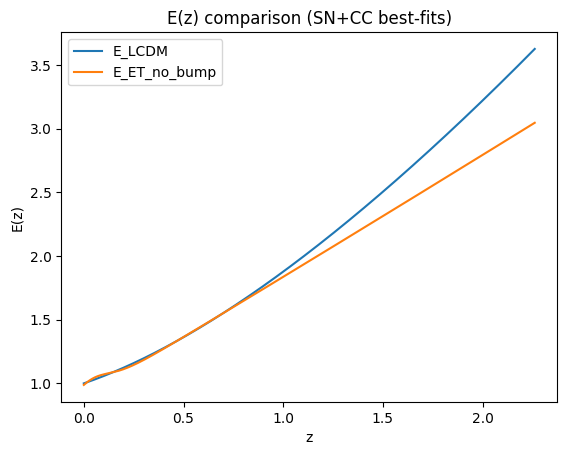

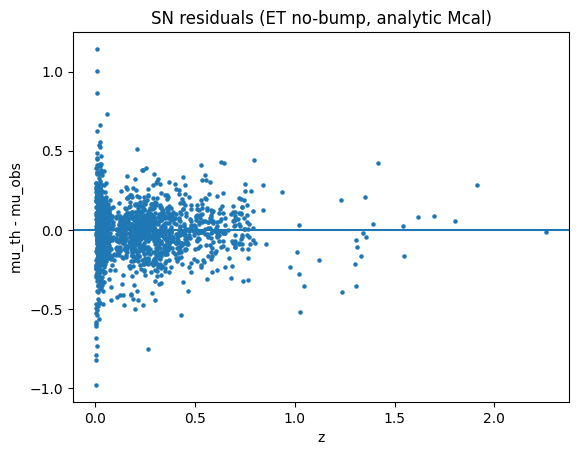

In [ ]:
# ============================================
# FIT COMPLET (NO-DRIVE) — ET no-bump + LCDM (SN+CC)
# + métriques “ΛCDM-like” sur observables (mu, H)
# ============================================

# --- deps ---
!pip -q install numpy pandas scipy matplotlib requests

import os, glob, gzip, shutil, subprocess, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.linalg import cho_factor, cho_solve, solve_triangular
from scipy.integrate import solve_ivp, cumulative_trapezoid
from scipy.optimize import least_squares, minimize
import requests

# -----------------------------
# 0) Data acquisition (NO DRIVE)
# -----------------------------
BASE = "/content/CFT_data"
os.makedirs(BASE, exist_ok=True)

def _run(cmd):
    subprocess.check_call(cmd, shell=True)

def ensure_git_repo(url, dest, branch_or_tag=None, depth=1):
    if os.path.exists(dest) and os.path.isdir(os.path.join(dest, ".git")):
        return
    if os.path.exists(dest):
        shutil.rmtree(dest)
    if branch_or_tag:
        _run(f"git clone --depth {depth} --branch {branch_or_tag} {url} {dest}")
    else:
        _run(f"git clone --depth {depth} {url} {dest}")

# GitHub repos
ensure_git_repo("https://github.com/CobayaSampler/sn_data.git",
                os.path.join(BASE, "sn_data-master"))
ensure_git_repo("https://github.com/CobayaSampler/bao_data.git",
                os.path.join(BASE, "bao_data-master"))
ensure_git_repo("https://gitlab.com/mmoresco/CCcovariance.git",
                os.path.join(BASE, "CCcovariance-master"))

PATHS = {
    "sn_data":   os.path.join(BASE, "sn_data-master"),
    "bao_data":  os.path.join(BASE, "bao_data-master"),
    "cc_cov":    os.path.join(BASE, "CCcovariance-master"),
}

print("[OK] Repos present:")
for k, v in PATHS.items():
    print(f"  {k:8s}: {os.path.exists(v)} | {v}")

def find_one(patterns, root):
    if root is None or not os.path.exists(root):
        return None
    for pat in patterns:
        hits = glob.glob(os.path.join(root, "**", pat), recursive=True)
        if hits:
            return sorted(hits)[0]
    return None

# SN: Pantheon+ SH0ES from sn_data-master
PPLUS_DAT = find_one(["*Pantheon+SH0ES*.dat", "*Pantheon*SH0ES*.dat"], PATHS["sn_data"])
PPLUS_COV = find_one(["*Pantheon+SH0ES*STAT+SYS*.cov", "*Pantheon*STAT*SYS*.cov"], PATHS["sn_data"])

# CC: BC03 table from CCcovariance
CC_TABLE = os.path.join(PATHS["cc_cov"], "data", "HzTable_MM_BC03.dat")
if not os.path.exists(CC_TABLE):
    CC_TABLE = find_one(["HzTable_MM_BC03.dat", "*BC03*.dat"], PATHS["cc_cov"])

# Guard
for p in [PPLUS_DAT, PPLUS_COV, CC_TABLE]:
    if p is None or not os.path.exists(p):
        raise FileNotFoundError(f"Missing required file: {p}")

print("\n[OK] Paths resolved (NO DRIVE):")
print("  SN_DAT =", PPLUS_DAT)
print("  SN_COV =", PPLUS_COV)
print("  CC_FILE=", CC_TABLE)

# -----------------------------
# 1) Linear algebra helpers
# -----------------------------
def load_dense_cov(path):
    """Load cov: supports N then N^2, NxN matrix, and N^2+1 (Pantheon+ style)."""
    with open(path, "r") as f:
        tokens = f.read().strip().split()

    # Try N then N^2
    try:
        N = int(float(tokens[0]))
        vals = np.array(list(map(float, tokens[1:])), dtype=np.float64)
        if vals.size == N*N:
            return vals.reshape(N, N)
        if vals.size == N*N + 1:
            # N^2+1 case after header N
            print("[SN_COV] Detected N^2+1 entries after N; dropping first element.")
            vals = vals[1:]
            return vals.reshape(N, N)
    except Exception:
        pass

    # Fallback: raw vector that might be N^2+1
    vals = np.array(list(map(float, tokens)), dtype=np.float64)
    n = int(np.sqrt(vals.size))
    if n*n == vals.size:
        return vals.reshape(n, n)
    if n*n == vals.size - 1:
        print("[SN_COV] Detected N^2+1 entries; dropped first element to reshape.")
        vals = vals[1:]
        return vals.reshape(n, n)

    raise ValueError(f"Cannot parse covariance file: size={vals.size}")

def make_spd_and_cholesky(C, name="C", jitter0_rel=1e-12, max_tries=12):
    C = np.array(C, dtype=np.float64, copy=True)
    C = 0.5*(C + C.T)

    # Warn asymmetry
    asym = np.linalg.norm(C - C.T) / max(np.linalg.norm(C), 1e-30)
    if asym > 1e-10:
        print(f"[WARN] {name} not perfectly symmetric (relative asym={asym:.2e}).")

    n = C.shape[0]
    diag = np.diag(C)
    if np.any(diag <= 0):
        shift = float(abs(np.min(diag)) + 1e-18)
        C += shift * np.eye(n)

    diag = np.diag(C)
    scale = float(np.median(diag)) if np.all(np.isfinite(diag)) else 1.0
    if not np.isfinite(scale) or scale <= 0:
        scale = 1.0

    jitter = 0.0
    for k in range(max_tries):
        try:
            Cf = C if jitter == 0 else (C + jitter*np.eye(n))
            cf = cho_factor(Cf, lower=True, overwrite_a=False, check_finite=False)
            if k > 0:
                print(f"{name}: Cholesky OK with jitter={jitter:.3e} (rel={jitter/scale:.3e})")
            return Cf, cf
        except np.linalg.LinAlgError:
            jitter = (jitter0_rel*scale) if k == 0 else (10.0*jitter)

    raise np.linalg.LinAlgError(f"{name}: failed to make PD after {max_tries} tries.")

def whiten(cf, r):
    L, lower = cf
    return solve_triangular(L, r, lower=True, check_finite=False)

# -----------------------------
# 2) Load SN + CC (SN uses full cov; CC uses diagonal here)
# -----------------------------
def load_sn_pantheon(dat_path, cov_path):
    df = pd.read_csv(dat_path, comment="#", sep=r"\s+", engine="python")
    cols = {c.lower(): c for c in df.columns}

    # z column
    if "zhd" in cols:
        zcol = cols["zhd"]
    elif "zcmb" in cols:
        zcol = cols["zcmb"]
    else:
        raise ValueError(f"SN .dat: cannot find zHD or zCMB. Columns={list(df.columns)}")

    # mu column: prefer mu_sh0es then mu then mub
    mu_key = None
    for k in ["mu_sh0es", "mu", "mub"]:
        if k in cols:
            mu_key = cols[k]
            break
    if mu_key is None:
        # fallback: any column containing 'mu'
        mucands = [c for c in df.columns if "mu" in c.lower()]
        if not mucands:
            raise ValueError(f"SN .dat: cannot find mu-like column. Columns={list(df.columns)}")
        mu_key = mucands[0]

    z = df[zcol].to_numpy(np.float64)
    mu = df[mu_key].to_numpy(np.float64)

    C_raw = load_dense_cov(cov_path)
    if C_raw.shape[0] != len(mu):
        raise ValueError(f"SN cov shape {C_raw.shape} != N_SN {len(mu)}")

    C, cf = make_spd_and_cholesky(C_raw, name="SN_cov")
    print(f"[SN] Using z='{zcol.lower()}', y='{mu_key.lower()}' | N={len(mu)}")
    return z, mu, C, cf

def load_cc_table(path):
    # HzTable_MM_BC03.dat is comma-separated with comments
    df = pd.read_csv(path, comment="#", header=None, sep=",")
    z  = df.iloc[:,0].to_numpy(np.float64)
    H  = df.iloc[:,1].to_numpy(np.float64)
    sH = df.iloc[:,2].to_numpy(np.float64)
    C  = np.diag(sH**2)
    cf = cho_factor(C, lower=True, overwrite_a=False, check_finite=False)
    return z, H, sH, C, cf

z_sn, mu_sn, C_sn, cf_sn = load_sn_pantheon(PPLUS_DAT, PPLUS_COV)
z_cc, H_cc, sH_cc, C_cc, cf_cc = load_cc_table(CC_TABLE)

print(f"[CC] N={len(z_cc)} z in [{z_cc.min():.3f},{z_cc.max():.3f}]")

# Common z-grid (SN+CC only)
zmax = float(max(z_sn.max(), z_cc.max()))
z_grid = np.linspace(0.0, zmax, 1200)

# -----------------------------
# 3) ET no-bump model (dynamic reconstruction)
# -----------------------------
gamma0 = 6.0
t_star = 1.0

def _safe_exp(x):
    return np.exp(np.clip(x, -80, 80))

def make_gfun(z_on, Delta):
    Delta = max(float(Delta), 1e-4)
    z_on = float(z_on)
    def g(z):
        z = np.asarray(z, float)
        return 1.0 / (1.0 + _safe_exp((z - z_on)/Delta))
    return g

def HD_and_dHD_A0(z, p4):
    # p4 = [H_hi, H_lo, zt, w]
    H_hi, H_lo, zt, w = map(float, p4)
    w = max(w, 1e-6)
    u = (np.asarray(z, float) - zt) / w
    eu = _safe_exp(u)
    S = 1.0 / (1.0 + eu)
    dSdz = -(1.0 / w) * S * (1.0 - S)

    HD  = H_hi + (H_lo - H_hi) * S
    dHD = (H_lo - H_hi) * dSdz
    return HD, dHD

def solve_y_A0(z_grid, p4, y_init, gfun):
    z0, z1 = float(z_grid[0]), float(z_grid[-1])

    def rhs(z, y):
        HD, dHD = HD_and_dHD_A0(z, p4)
        HD = max(float(HD), 1e-12)
        gz = float(gfun(z))
        return -gamma0/((1.0+z)*HD) - gz*y*(float(dHD)/HD)

    sol = solve_ivp(rhs, (z0, z1), [float(y_init)],
                    t_eval=z_grid, rtol=1e-6, atol=1e-9)
    if not sol.success:
        return None
    return sol.y[0]

def model_E_A0(z_grid, p4, y_init, gfun, zref_max=0.02):
    y = solve_y_A0(z_grid, p4, y_init, gfun)
    if y is None:
        return None

    HD, dHD = HD_and_dHD_A0(z_grid, p4)
    if np.any(~np.isfinite(HD)) or np.any(HD <= 0):
        return None

    t = t_star * np.exp(y)
    denom = 1.0 + gfun(z_grid) * ((1.0+z_grid)/gamma0) * dHD * y
    if np.any(~np.isfinite(denom)) or np.any(np.abs(denom) < 1e-6):
        return None

    H = HD / (gamma0 * t * denom)

    mref = (z_grid <= zref_max)
    if not np.any(mref):
        mref = (z_grid == z_grid.min())
    Href = float(np.mean(H[mref]))
    if not np.isfinite(Href) or abs(Href) < 1e-12:
        return None

    return H / Href  # E(z)

# -----------------------------
# 4) SN+CC likelihood with analytic nuisances (Mcal, H0)
# -----------------------------
def best_Mcal(mu_obs, mu_star, cf_cov):
    r = mu_obs - mu_star
    Cinv_r = cho_solve(cf_cov, r, check_finite=False)
    Cinv_1 = cho_solve(cf_cov, np.ones_like(r), check_finite=False)
    return float(np.dot(np.ones_like(r), Cinv_r) / np.dot(np.ones_like(r), Cinv_1))

def best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid):
    Ecc = np.interp(z_cc, z_grid, E_grid)
    Cinv_H = cho_solve(cf_cc, H_cc, check_finite=False)
    Cinv_E = cho_solve(cf_cc, Ecc, check_finite=False)
    return float(np.dot(Ecc, Cinv_H) / np.dot(Ecc, Cinv_E))

def mu_star_from_Egrid(z_sn, z_grid, E_grid):
    invE = 1.0/np.maximum(E_grid, 1e-12)
    chi_grid = cumulative_trapezoid(invE, z_grid, initial=0.0)
    chi_sn = np.interp(z_sn, z_grid, chi_grid)
    dL_sn = (1.0 + z_sn) * np.maximum(chi_sn, 1e-14)
    return 5.0*np.log10(dL_sn), chi_grid

N_sn = len(z_sn)
N_cc = len(z_cc)
N_tot = N_sn + N_cc

def residuals_ET_A0(x, z_on, Delta):
    # x = [H_hi,H_lo,zt,w,y0]
    p4 = x[:4]
    y0 = x[4]
    gfun = make_gfun(z_on, Delta)

    E_grid = model_E_A0(z_grid, p4, y0, gfun)
    if E_grid is None or np.any(~np.isfinite(E_grid)):
        return 1e6*np.ones(N_tot, dtype=np.float64)

    mu_star, _ = mu_star_from_Egrid(z_sn, z_grid, E_grid)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = whiten(cf_sn, r_sn)

    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (H0*Ecc) - H_cc
    u_cc = whiten(cf_cc, r_cc)

    return np.concatenate([u_sn, u_cc])

def eval_ET_A0(x, z_on, Delta):
    p4 = x[:4]; y0 = x[4]
    gfun = make_gfun(z_on, Delta)
    E_grid = model_E_A0(z_grid, p4, y0, gfun)
    mu_star, _ = mu_star_from_Egrid(z_sn, z_grid, E_grid)

    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = whiten(cf_sn, r_sn)

    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid)
    Ecc = np.interp(z_cc, z_grid, E_grid)
    r_cc = (H0*Ecc) - H_cc
    u_cc = whiten(cf_cc, r_cc)

    chi2_sn = float(np.dot(u_sn,u_sn))
    chi2_cc = float(np.dot(u_cc,u_cc))

    return dict(
        x=np.array(x, float),
        z_on=float(z_on), Delta=float(Delta),
        Mcal=float(Mcal), H0=float(H0),
        chi2_sn=chi2_sn, chi2_cc=chi2_cc, chi2_tot=chi2_sn+chi2_cc,
        E_grid=E_grid
    )

# -----------------------------
# 5) Fit ET no-bump (scan gating then refine)
# -----------------------------
# Bounds: [H_hi,H_lo,zt,w,y0]
LB = np.array([3.0, 5.0, 0.00, 0.03, -50.0], dtype=np.float64)
UB = np.array([6.0, 25.0, 1.20, 5.00,  50.0], dtype=np.float64)
X0 = np.array([4.0, 10.0, 0.65, 0.12, 0.0], dtype=np.float64)

ZON_GRID   = np.arange(0.55, 0.91, 0.05)
DELTA_GRID = np.array([0.05, 0.07, 0.10, 0.12, 0.15], dtype=np.float64)

best_cost = np.inf
best_pack = None

for z_on in ZON_GRID:
    for Delta in DELTA_GRID:
        res = least_squares(
            residuals_ET_A0, X0,
            bounds=(LB, UB),
            args=(float(z_on), float(Delta)),
            loss="soft_l1", f_scale=1.0,
            max_nfev=2000
        )
        if res.success and np.isfinite(res.cost) and res.cost < best_cost:
            best_cost = float(res.cost)
            best_pack = (float(z_on), float(Delta), res)
            print("New best:", "z_on", float(z_on), "Delta", float(Delta), "cost", best_cost)

if best_pack is None:
    raise RuntimeError("ET no-bump scan failed: no successful solution.")

z_on_best, Delta_best, res0 = best_pack

res_best = least_squares(
    residuals_ET_A0, res0.x,
    bounds=(LB, UB),
    args=(z_on_best, Delta_best),
    loss="soft_l1", f_scale=1.0,
    max_nfev=8000
)

fitE = eval_ET_A0(res_best.x, z_on_best, Delta_best)

print("\n=== ET no-bump (SN+CC) BEST ===")
print("z_on_best =", fitE["z_on"], "Delta_best =", fitE["Delta"])
print("x=[H_hi,H_lo,zt,w,y0] =", fitE["x"])
print("H0 =", fitE["H0"])
print("Mcal =", fitE["Mcal"])
print("chi2_sn =", fitE["chi2_sn"])
print("chi2_cc =", fitE["chi2_cc"])
print("chi2_tot =", fitE["chi2_tot"])

# -----------------------------
# 6) Fit LCDM (SN+CC) in same style (analytic Mcal, H0)
# -----------------------------
def E_lcdm_grid(Om):
    Om = float(Om)
    if Om <= 0.01 or Om >= 0.99:
        return None
    return np.sqrt(Om*(1.0+z_grid)**3 + (1.0-Om))

def obj_lcdm(theta):
    Om = float(theta[0])
    E_grid_L = E_lcdm_grid(Om)
    if E_grid_L is None:
        return 1e30

    mu_star, _ = mu_star_from_Egrid(z_sn, z_grid, E_grid_L)
    Mcal = best_Mcal(mu_sn, mu_star, cf_sn)
    r_sn = (mu_star + Mcal) - mu_sn
    u_sn = whiten(cf_sn, r_sn)

    H0 = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid_L)
    Ecc = np.interp(z_cc, z_grid, E_grid_L)
    r_cc = (H0*Ecc) - H_cc
    u_cc = whiten(cf_cc, r_cc)

    return float(np.dot(u_sn,u_sn) + np.dot(u_cc,u_cc))

resL = minimize(obj_lcdm, x0=np.array([0.3]), bounds=[(0.05, 0.6)], method="L-BFGS-B")
Om_hat = float(resL.x[0])

E_grid_L = E_lcdm_grid(Om_hat)
mu_star_L, _ = mu_star_from_Egrid(z_sn, z_grid, E_grid_L)
Mcal_L = best_Mcal(mu_sn, mu_star_L, cf_sn)
H0_L = best_H0_from_CC(z_cc, H_cc, cf_cc, z_grid, E_grid_L)

# chi2 splits LCDM
r_sn_L = (mu_star_L + Mcal_L) - mu_sn
u_sn_L = whiten(cf_sn, r_sn_L)
chi2_sn_L = float(np.dot(u_sn_L,u_sn_L))

Ecc_L = np.interp(z_cc, z_grid, E_grid_L)
r_cc_L = (H0_L*Ecc_L) - H_cc
u_cc_L = whiten(cf_cc, r_cc_L)
chi2_cc_L = float(np.dot(u_cc_L,u_cc_L))

print("\n=== LCDM (SN+CC) BEST ===")
print("Om_hat =", Om_hat)
print("H0 =", float(H0_L))
print("Mcal =", float(Mcal_L))
print("chi2_sn =", chi2_sn_L)
print("chi2_cc =", chi2_cc_L)
print("chi2_tot =", chi2_sn_L + chi2_cc_L)

# -----------------------------
# 7) “ΛCDM-like” metrics on observables
# -----------------------------
# SN: compare mu_th (after analytic Mcal)
mu_th_E = (mu_star_from_Egrid(z_sn, z_grid, fitE["E_grid"])[0] + fitE["Mcal"])
mu_th_L = (mu_star_L + Mcal_L)
dmu = mu_th_E - mu_th_L
rmse_dmu = float(np.sqrt(np.mean(dmu**2)))
max_dmu  = float(np.max(np.abs(dmu)))

# CC: compare H(z) at CC points (after analytic H0)
Hz_E = fitE["H0"] * np.interp(z_cc, z_grid, fitE["E_grid"])
Hz_L = H0_L       * np.interp(z_cc, z_grid, E_grid_L)
dH = Hz_E - Hz_L
rmse_dH = float(np.sqrt(np.mean(dH**2)))
max_dH  = float(np.max(np.abs(dH)))

print("\n=== like-ΛCDM metrics (on fitted observables) ===")
print(f"SN: RMSE(dmu)={rmse_dmu:.3e} mag | max|dmu|={max_dmu:.3e} mag")
print(f"CC: RMSE(dH) ={rmse_dH:.3e} km/s/Mpc | max|dH| ={max_dH:.3e}")

# -----------------------------
# 8) Minimal summary table + quick plots
# -----------------------------
summary = pd.DataFrame([
    {"model":"LCDM (SN+CC)", "k_shape":1, "H0":float(H0_L), "chi2_sn":chi2_sn_L, "chi2_cc":chi2_cc_L, "chi2_tot":chi2_sn_L+chi2_cc_L, "params":"Om"},
    {"model":"ET no-bump (SN+CC)", "k_shape":5, "H0":float(fitE["H0"]), "chi2_sn":fitE["chi2_sn"], "chi2_cc":fitE["chi2_cc"], "chi2_tot":fitE["chi2_tot"], "params":"H_hi,H_lo,zt,w,y0"},
])
print("\n=== SUMMARY ===")
print(summary.to_string(index=False))

plt.figure()
plt.plot(z_grid, E_grid_L, label="E_LCDM")
plt.plot(z_grid, fitE["E_grid"], label="E_ET_no_bump")
plt.xlabel("z"); plt.ylabel("E(z)")
plt.title("E(z) comparison (SN+CC best-fits)")
plt.legend(); plt.show()

plt.figure()
plt.scatter(z_sn, (mu_th_E - mu_sn), s=5, label="ET residuals")
plt.axhline(0.0)
plt.xlabel("z"); plt.ylabel("mu_th - mu_obs")
plt.title("SN residuals (ET no-bump, analytic Mcal)")
plt.show()
